DSE 6000 - Final Project
Team Members Josh Rieck, Ryan Pykor, Seth Hanson, Ameen Alkhabbaz

#**Start by importing all of the necessary libraries into Colab**

In [ ]:
import pandas as pd
from urllib.request import urlopen
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
import datetime as dt

In [ ]:
!pip install plotly==4.5

     |████████████████████████████████| 7.1MB 9.3MB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


#**Upload the data sets needed for our analysis**

In [ ]:
url = 'https://storage.googleapis.com/ryan_test_bucket/Covid-19_Tests_by_County_2020-11-30_709022_7.csv' #'https://raw.githubusercontent.com/jmrieck17/Covid-County-By-Test/main/Covid-19_Tests_by_County_2020-11-30_709022_7.csv'
CovidByCounty = pd.read_csv(url)

In [ ]:
url1 = 'https://storage.googleapis.com/ryan_test_bucket/Michigan_County_Population_Data.csv' #'https://raw.githubusercontent.com/jmrieck17/Covid-County-By-Test/main/Michigan_County_Population_Data.csv'
MICountyPop = pd.read_csv(url1)

NameError: ignored

In [ ]:
url2 = 'https://storage.googleapis.com/ryan_test_bucket/Cases_and_Deaths_by_County_2020-11-28_708957_7.csv' #'https://raw.githubusercontent.com/jmrieck17/Covid-County-By-Test/main/Cases_and_Deaths_by_County_2020-11-28_708957_7.csv'
CountyDeaths = pd.read_csv(url2)

In [ ]:
# this dataframe contains FIPS information for mapping graphs that will be used later
# source: https://www2.census.gov/programs-surveys/popest/geographies/2019/all-geocodes-v2019.xlsx

url3 = 'https://raw.githubusercontent.com/jmrieck17/Covid-County-By-Test/main/all-geocodes-v2019.csv'
FIPSCodes = pd.read_csv(url3)

In [ ]:
url_ = 'https://storage.googleapis.com/ryan_test_bucket/Mental_Health_Care_in_the_Last_4_Weeks.csv'

In [ ]:
url_1 = 'https://storage.googleapis.com/ryan_test_bucket/Indicators_of_Anxiety_or_Depression_Based_on_Reported_Frequency_of_Symptoms_During_Last_7_Days.csv'
anxiety_depression_data = pd.read_csv(url_1)


In [ ]:
url_2 = 'https://storage.googleapis.com/ryan_test_bucket/Unemployment_Rate.csv'

#**Cleaning the Data**

This is our first data set that we imported. To clean this set, we will need to strip the Test Type column and create three separate columns for Diagnostic, Serology, and Total Test counts. Our goal will be to create common County column on all data sets to prepare for merger of the data into one dataset.

In [ ]:
# Reformat the Covid test type data so the Test Types count get their own columns for all 83 counties
# Seth's code modified from Lab 1

diagnosticData = CovidByCounty.loc[CovidByCounty["TestType"]=="Diagnostic"]
del diagnosticData["TestType"]
diagnosticData = diagnosticData.reset_index(drop=True)

serologyData = CovidByCounty.loc[CovidByCounty["TestType"]=="Serology"]
del serologyData["TestType"]
serologyData = serologyData.reset_index(drop=True)

totalsData = CovidByCounty.loc[CovidByCounty["TestType"]=="Total"]
del totalsData["TestType"]
totalsData = totalsData.reset_index(drop=True)

TestTypeData = diagnosticData
TestTypeData["Population(1000's)"] = round((TestTypeData["Count"]/TestTypeData["RatePerMillion"])*1000,1)
TestTypeData = TestTypeData.rename(columns={"Count" : "Count_Diagnostic"})
TestTypeData["Count_Serology"] = serologyData["Count"]
TestTypeData["Count_Total"] = totalsData["Count"]
TestTypeData = TestTypeData[['COUNTY','Count_Diagnostic','Count_Serology','Count_Total',"Population(1000's)"]]

# Checking the TestTypeData dataframe to see which rows contain any null values
is_NaN = TestTypeData.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = TestTypeData[row_has_NaN]
print(rows_with_NaN)

TestTypeData = TestTypeData.dropna()
TestTypeData = TestTypeData[TestTypeData.COUNTY != 'Detroit City']

          COUNTY  Count_Diagnostic  ...  Count_Total  Population(1000's)
19  Correctional            346515  ...       359629                 NaN
81       Unknown            267657  ...       286482                 NaN

[2 rows x 5 columns]


Next, we'll do some light formatting of the population data set in order to prepare for eventual data merger.

In [ ]:
MICountyPop['CTYNAME'] = MICountyPop['CTYNAME'].str.replace(' County' , '')
MICountyPop = MICountyPop.rename(columns={'CTYNAME':'COUNTY'})

# noticed that county names for St Clair and St Joseph were different in each data frame
# changed names of both so they will match eachother for the merge
MICountyPop.loc[MICountyPop['COUNTY']== 'St. Clair', 'COUNTY'] = "St Clair"
MICountyPop.loc[MICountyPop['COUNTY']== 'St. Joseph', 'COUNTY'] = "St Joseph"

After that, we'll clean up the County Deaths data set and prepare it for the merge

In [ ]:
# reformatting the Cases and Deaths table to move probable cases and deaths into columns

ConfirmedData = CountyDeaths.loc[CountyDeaths['CASE_STATUS']=='Confirmed']
del ConfirmedData['CASE_STATUS']
ConfirmedData = ConfirmedData.reset_index(drop=True)

ProbableData = CountyDeaths.loc[CountyDeaths['CASE_STATUS']=='Probable']
del ProbableData['CASE_STATUS']
ProbableData = ProbableData.reset_index(drop=True)

CaseAndDeathData = ConfirmedData
CaseAndDeathData.columns = ['COUNTY' , 'Confirmed_Cases' , 'Confirmed_Deaths' , 'Updated']
CaseAndDeathData['Probable_Cases'] = ProbableData['Cases']
CaseAndDeathData['Probable_Deaths'] = ProbableData['Deaths']
del CaseAndDeathData['Updated']

# some Rows that are in this data set and not others:
# Out-of-State, Unknown, MDOC, FCI, Detroit City
# dropping these rows so there is a uniform 83 Michigan counties in this dataframe
CaseAndDeathData = CaseAndDeathData[CaseAndDeathData.COUNTY != 'Out-of-State']
CaseAndDeathData = CaseAndDeathData[CaseAndDeathData.COUNTY != 'Unknown']
CaseAndDeathData = CaseAndDeathData[CaseAndDeathData.COUNTY != 'MDOC']
CaseAndDeathData = CaseAndDeathData[CaseAndDeathData.COUNTY != 'FCI']
CaseAndDeathData = CaseAndDeathData[CaseAndDeathData.COUNTY != 'Detroit City']

And finally, we have the FIPS data set that contains information that we can use to create detailed geographic maps for our analysis

In [ ]:
FIPSCodes.columns = ['Summary_Level' , 'State_Code', 'County_Code' , 'County_Sub_Code' , 'Place_Code' , 'City_Code' , 'COUNTY']
FIPSCodes['County_Code'] = FIPSCodes['County_Code'].apply(lambda x: '{0:0>3}'.format(x))
MIFIPSCodes = FIPSCodes.loc[(FIPSCodes['State_Code'] == 26) & (FIPSCodes['Summary_Level'] == 50)]
MIFIPSCodes['COUNTY'] = MIFIPSCodes['COUNTY'].str.replace(' County' , '')
MIFIPSCodes.loc[MIFIPSCodes['COUNTY']== 'St. Clair', 'COUNTY'] = "St Clair"
MIFIPSCodes.loc[MIFIPSCodes['COUNTY']== 'St. Joseph', 'COUNTY'] = "St Joseph"
MIFIPSCodes['FIPS'] = MIFIPSCodes['State_Code'].astype(str) + MIFIPSCodes['County_Code'].astype(str)
FinalMIFIPSCodes = MIFIPSCodes.drop(['County_Sub_Code' , 'Place_Code' , 'Summary_Level', 'City_Code'], axis = 1)

#**Merging the Data**

In [ ]:
MergeData1 = pd.merge(MICountyPop , TestTypeData)

MergeData2 = pd.merge(MergeData1 , CaseAndDeathData)
# Adding in a categorical column into the data set that breaks state out by region
Counties_By_Region = {'Midland':'Saginaw Region' , 'Bay':'Saginaw Region' , 'Saginaw':'Saginaw Region' , 
                      'Shiawassee':'Lansing Region' , 'Ingham':'Lansing Region' , 'Jackson':'Jackson Region' ,
                      'Hillsdale':'Jackson Region' , 'Lenawee':'Jackson Region' , 'Monroe':'Detroit Region' ,
                      'Wayne':'Detroit Region' , 'Macomb':'Detroit Region' , 'St Clair':'Detroit Region' , 
                      'Sanilac':'Saginaw Region' , 'Huron':'Saginaw Region' , 'Tuscola':'Saginaw Region' , 
                      'Genesee':'Detroit Region' , 'Livingston':'Detroit Region' , 
                      'Washtenaw':'Detroit Region' , 'Oakland':'Detroit Region' , 'Lapeer':'Detroit Region' , 
                      'Isabella':'Grand Rapids Region' , 'Mecosta':'Grand Rapids Region' , 
                      'Newaygo':'Grand Rapids Region' , 'Oceana':'Grand Rapids Region' , 
                      'Muskegon':'Grand Rapids Region' , 'Ottawa':'Grand Rapids Region' , 
                      'Allegan':'Kalamazoo Region' , 'Van Buren':'Kalamazoo Region' , 
                      'Berrien':'Kalamazoo Region' , 'Cass':'Kalamazoo Region' , 
                      'St Joseph':'Kalamazoo Region' , 'Branch':'Kalamazoo Region' , 
                      'Calhoun':'Kalamazoo Region' , 'Eaton':'Lansing Region' , 'Clinton':'Lansing Region' , 
                      'Gratiot':'Lansing Region' ,'Montcalm':'Grand Rapids Region' , 
                      'Kent':'Grand Rapids Region' , 'Ionia':'Grand Rapids Region' , 
                      'Barry':'Kalamazoo Region' , 'Kalamazoo':'Kalamazoo Region' , 
                      'Arenac':'Saginaw Region' , 'Gladwin':'Saginaw Region' , 
                      'Roscommon':'Traverse City Region' , 'Crawford':'Traverse City Region' , 
                      'Otsego':'Traverse City Region' , 'Cheboygan':'Traverse City Region' , 
                      'Presque Isle':'Traverse City Region' , 'Alpena':'Traverse City Region' , 
                      'Alcona':'Saginaw Region' , 'Iosco':'Saginaw Region' , 'Ogemaw':'Saginaw Region' , 
                      'Oscoda':'Saginaw Region' , 'Montmorency':'Traverse City Region' , 
                      'Clare':'Grand Rapids Region' ,  'Osceola':'Grand Rapids Region' , 
                      'Lake':'Grand Rapids Region' , 'Mason':'Grand Rapids Region' , 
                      'Manistee':'Traverse City Region' , 'Benzie':'Traverse City Region' , 
                      'Leelanau':'Traverse City Region' , 'Emmet':'Traverse City Region' , 
                      'Charlevoix':'Traverse City Region' , 'Antrim':'Traverse City Region' , 
                      'Kalkaska':'Traverse City Region' , 'Missaukee':'Traverse City Region' , 
                      'Wexford':'Traverse City Region' , 'Grand Traverse':'Traverse City Region' , 
                      'Chippewa':'Upper Peninsula' ,  'Mackinac':'Upper Peninsula' , 
                      'Luce':'Upper Peninsula' , 'Schoolcraft':'Upper Peninsula' , 
                      'Alger':'Upper Peninsula' , 'Delta':'Upper Peninsula' , 'Menominee':'Upper Peninsula' , 
                      'Dickinson':'Upper Peninsula' , 'Marquette':'Upper Peninsula' , 'Iron':'Upper Peninsula' , 
                      'Baraga':'Upper Peninsula' , 'Houghton':'Upper Peninsula' , 
                      'Keweenaw':'Upper Peninsula' , 'Ontonagon':'Upper Peninsula' , 
                      'Gogebic':'Upper Peninsula'}
MergeData2["MERC_Regions"] = MergeData2['COUNTY'].map(Counties_By_Region)
del MergeData2["Population(1000's)"]
del MergeData2["GrowthRate"]
MergeData2.sort_values('COUNTY', ascending=True)

#Population Density in People per square mile, added 12/4
#From 2000 Census Data https://www.michigan.gov/documents/co_mcd_26764_7.PDF
Pop_Density = {'Alcona' : 17.4, 'Alger' : 10.7, 'Allegan' : 127.7, 'Alpena' : 54.5, 'Antrim' : 48.5, 'Arenac' : 47.1, 'Baraga' : 9.7, 'Barry' : 102.1, 'Bay' : 248, 'Benzie' : 49.8, 'Berrien' : 284.5, 'Branch' : 90.2, 'Calhoun' : 194.7, 'Cass' : 103.8, 'Charlevoix' : 62.6, 'Cheboygan' : 37, 'Chippewa' : 24.7, 'Clare' : 55.1, 'Clinton' : 113.3, 'Crawford' : 25.6, 'Delta' : 32.9, 'Dickinson' : 35.8, 'Eaton' : 179.8, 'Emmet' : 67.2, 'Genesee' : 681.9, 'Gladwin' : 51.3, 'Gogebic' : 15.8, 'Grand Traverse' : 167, 'Gratiot' : 74.2, 'Hillsdale' : 77.7, 'Houghton' : 35.6, 'Huron' : 43.1, 'Ingham' : 499.5, 'Ionia' : 107.3, 'Iosco' : 49.8, 'Iron' : 11.3, 'Isabella' : 110.3, 'Jackson' : 224.2, 'Kalamazoo' : 424.7, 'Kalkaska' : 29.5, 'Kent' : 670.8, 'Keweenaw' : 4.3, 'Lake' : 20, 'Lapeer' : 134.4, 'Leelanau' : 60.6, 'Lenawee' : 131.8, 'Livingston' : 276.1, 'Luce' : 7.8, 'Mackinac' : 11.7, 'Macomb' : 1640.5, 'Manistee' : 45.1, 'Marquette' : 35.5, 'Mason' : 57.1, 'Mecosta' : 73, 'Menominee' : 24.3, 'Midland' : 159, 'Missaukee' : 25.5, 'Monroe' : 264.8, 'Montcalm' : 86.5, 'Montmorency' : 18.8, 'Muskegon' : 334.3, 'Newaygo' : 56.8, 'Oakland' : 1368.6, 'Oceana' : 49.7, 'Ogemaw' : 38.4, 'Ontonagon' : 6, 'Osceola' : 41, 'Oscoda' : 16.7, 'Otsego' : 45.3, 'Ottawa' : 421.3, 'Presque Isle' : 21.8, 'Roscommon' : 48.8, 'Saginaw' : 259.6, 'St Clair' : 226.7, 'St Joseph' : 123.9, 'Sanilac' : 46.2, 'Schoolcraft' : 7.6, 'Shiawassee' : 133.1, 'Tuscola' : 71.1, 'Van Buren' : 124.8, 'Washtenaw' : 454.8, 'Wayne' : 3356.1, 'Wexford' : 53.9}
MergeData2["Population_Density"] = MergeData2['COUNTY'].map(Pop_Density)
#MergeData2.sort_values('COUNTY', ascending=True)

#Binning county population density
MergeData2['Population_Density_Bins'] = pd.cut(MergeData2['Population_Density'], [0,100,500,10000])

#Computing Test Rate as Percentage of Total Tests divided by Population
MergeData2['Test_Rate'] = MergeData2['Count_Total']/MergeData2['pop2020']*100

#Computing Case Rate as Percentage of Confirmed Cases divided by Population
MergeData2['Confirmed_Case_Rate'] = MergeData2['Confirmed_Cases']/MergeData2['pop2020']*100

#Computing Death Rate as Percentage of Confirmed and Probable Deaths divided by confirmed and probable cases
MergeData2['Case_Death_Rate'] = (MergeData2['Confirmed_Deaths']+MergeData2['Probable_Deaths'])/(MergeData2['Confirmed_Cases']+MergeData2['Probable_Cases'])

MergeData3 = pd.merge(MergeData2 , FinalMIFIPSCodes)
MergeData3['FIPS'] = MergeData3['FIPS'].astype(str)

MergeData3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83 entries, 0 to 82
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   COUNTY                   83 non-null     object  
 1   pop2020                  83 non-null     int64   
 2   Count_Diagnostic         83 non-null     int64   
 3   Count_Serology           83 non-null     int64   
 4   Count_Total              83 non-null     int64   
 5   Confirmed_Cases          83 non-null     int64   
 6   Confirmed_Deaths         83 non-null     int64   
 7   Probable_Cases           83 non-null     int64   
 8   Probable_Deaths          83 non-null     int64   
 9   MERC_Regions             83 non-null     object  
 10  Population_Density       83 non-null     float64 
 11  Population_Density_Bins  83 non-null     category
 12  Test_Rate                83 non-null     float64 
 13  Confirmed_Case_Rate      83 non-null     float64 
 14  Case_Death_R

In [ ]:
MergeData3.to_csv(r'C:\Users\joshr\Desktop\DSE 6000\Final Project', header = True)

In [ ]:
DetData = MergeData3.loc[MergeData3['MERC_Regions'] == 'Detroit Region']
GRData =  MergeData3.loc[MergeData3['MERC_Regions'] == 'Grand Rapids Region']
JackData = MergeData3.loc[MergeData3['MERC_Regions'] == 'Jackson Region']
KalaData = MergeData3.loc[MergeData3['MERC_Regions'] == 'Kalamazoo Region']
LansData = MergeData3.loc[MergeData3['MERC_Regions'] == 'Lansing Region']
SagData = MergeData3.loc[MergeData3['MERC_Regions'] == 'Saginaw Region']
TCData = MergeData3.loc[MergeData3['MERC_Regions'] == 'Traverse City Region']
UPData = MergeData3.loc[MergeData3['MERC_Regions'] == 'Upper Peninsula']

Pct_Pop_Det = round((DetData['pop2020'].sum() / MergeData3['pop2020'].sum()) * 100, 0)
Pct_Pop_GR =  round((GRData['pop2020'].sum() / MergeData3['pop2020'].sum()) * 100, 0)
Pct_Pop_Jack = round((JackData['pop2020'].sum() / MergeData3['pop2020'].sum()) * 100, 0)
Pct_Pop_Kala = round((KalaData['pop2020'].sum() / MergeData3['pop2020'].sum()) * 100, 0)
Pct_Pop_Lans = round((LansData['pop2020'].sum() / MergeData3['pop2020'].sum()) * 100, 0)
Pct_Pop_Sag = round((SagData['pop2020'].sum() / MergeData3['pop2020'].sum()) * 100, 0)
Pct_Pop_TC = round((TCData['pop2020'].sum() / MergeData3['pop2020'].sum()) * 100, 0)
Pct_Pop_UP = round((UPData['pop2020'].sum() / MergeData3['pop2020'].sum()) * 100, 0)

Pct_ConfD_Det = round((DetData['Confirmed_Deaths'].sum() / MergeData3['Confirmed_Deaths'].sum()) * 100, 0)
Pct_ConfD_GR = round((GRData['Confirmed_Deaths'].sum() / MergeData3['Confirmed_Deaths'].sum()) * 100, 0)
Pct_ConfD_Jack = round((JackData['Confirmed_Deaths'].sum() / MergeData3['Confirmed_Deaths'].sum()) * 100, 0)
Pct_ConfD_Kala = round((KalaData['Confirmed_Deaths'].sum() / MergeData3['Confirmed_Deaths'].sum()) * 100, 0)
Pct_ConfD_Lans = round((LansData['Confirmed_Deaths'].sum() / MergeData3['Confirmed_Deaths'].sum()) * 100, 0)
Pct_ConfD_Sag = round((SagData['Confirmed_Deaths'].sum() / MergeData3['Confirmed_Deaths'].sum()) * 100, 0)
Pct_ConfD_TC = round((TCData['Confirmed_Deaths'].sum() / MergeData3['Confirmed_Deaths'].sum()) * 100, 0)
Pct_ConfD_UP = round((UPData['Confirmed_Deaths'].sum() / MergeData3['Confirmed_Deaths'].sum()) * 100, 0)

#**Analysis **

#Understanding the Data Set

In [ ]:
MergeData3.head(3)

COUNTY  pop2020  Count_Diagnostic  ...  State_Code  County_Code   FIPS
0    Wayne  1749150            735038  ...          26          163  26163
1  Oakland  1265240            731814  ...          26          125  26125
2   Macomb   880325            450952  ...          26          099  26099

[3 rows x 18 columns]

In [ ]:
MergeData3.describe()

pop2020  Count_Diagnostic  ...  Case_Death_Rate  State_Code
count  8.300000e+01         83.000000  ...        83.000000        83.0
mean   1.209018e+05      68683.060241  ...         0.018318        26.0
std    2.609064e+05     135502.233930  ...         0.009893         0.0
min    2.135000e+03       1231.000000  ...         0.000000        26.0
25%    2.243750e+04       8882.500000  ...         0.011733        26.0
50%    3.712300e+04      23033.000000  ...         0.016086        26.0
75%    9.598050e+04      58600.000000  ...         0.023468        26.0
max    1.749150e+06     735038.000000  ...         0.050909        26.0

[8 rows x 13 columns]

Above is the descriptive statistics on the merged data set we compiled.

Text(0.5, 1.0, 'Heatmap of COVID-19 Data')

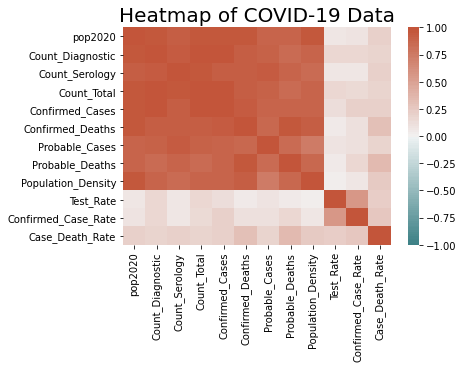

In [ ]:
corr = pd.DataFrame(MergeData2).corr()
ax = plt.axes()
sns.heatmap(corr, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(200, 20, n=100))
ax.set_title('Heatmap of COVID-19 Data',fontsize = 20)

Above is a heatmap of all variables in our data set cross-tabbed with one another. You will notice that there are very few negatively correlated variables. Many of these variables, such as the testing rate and the confirmation rate are intuitively correlated with one another

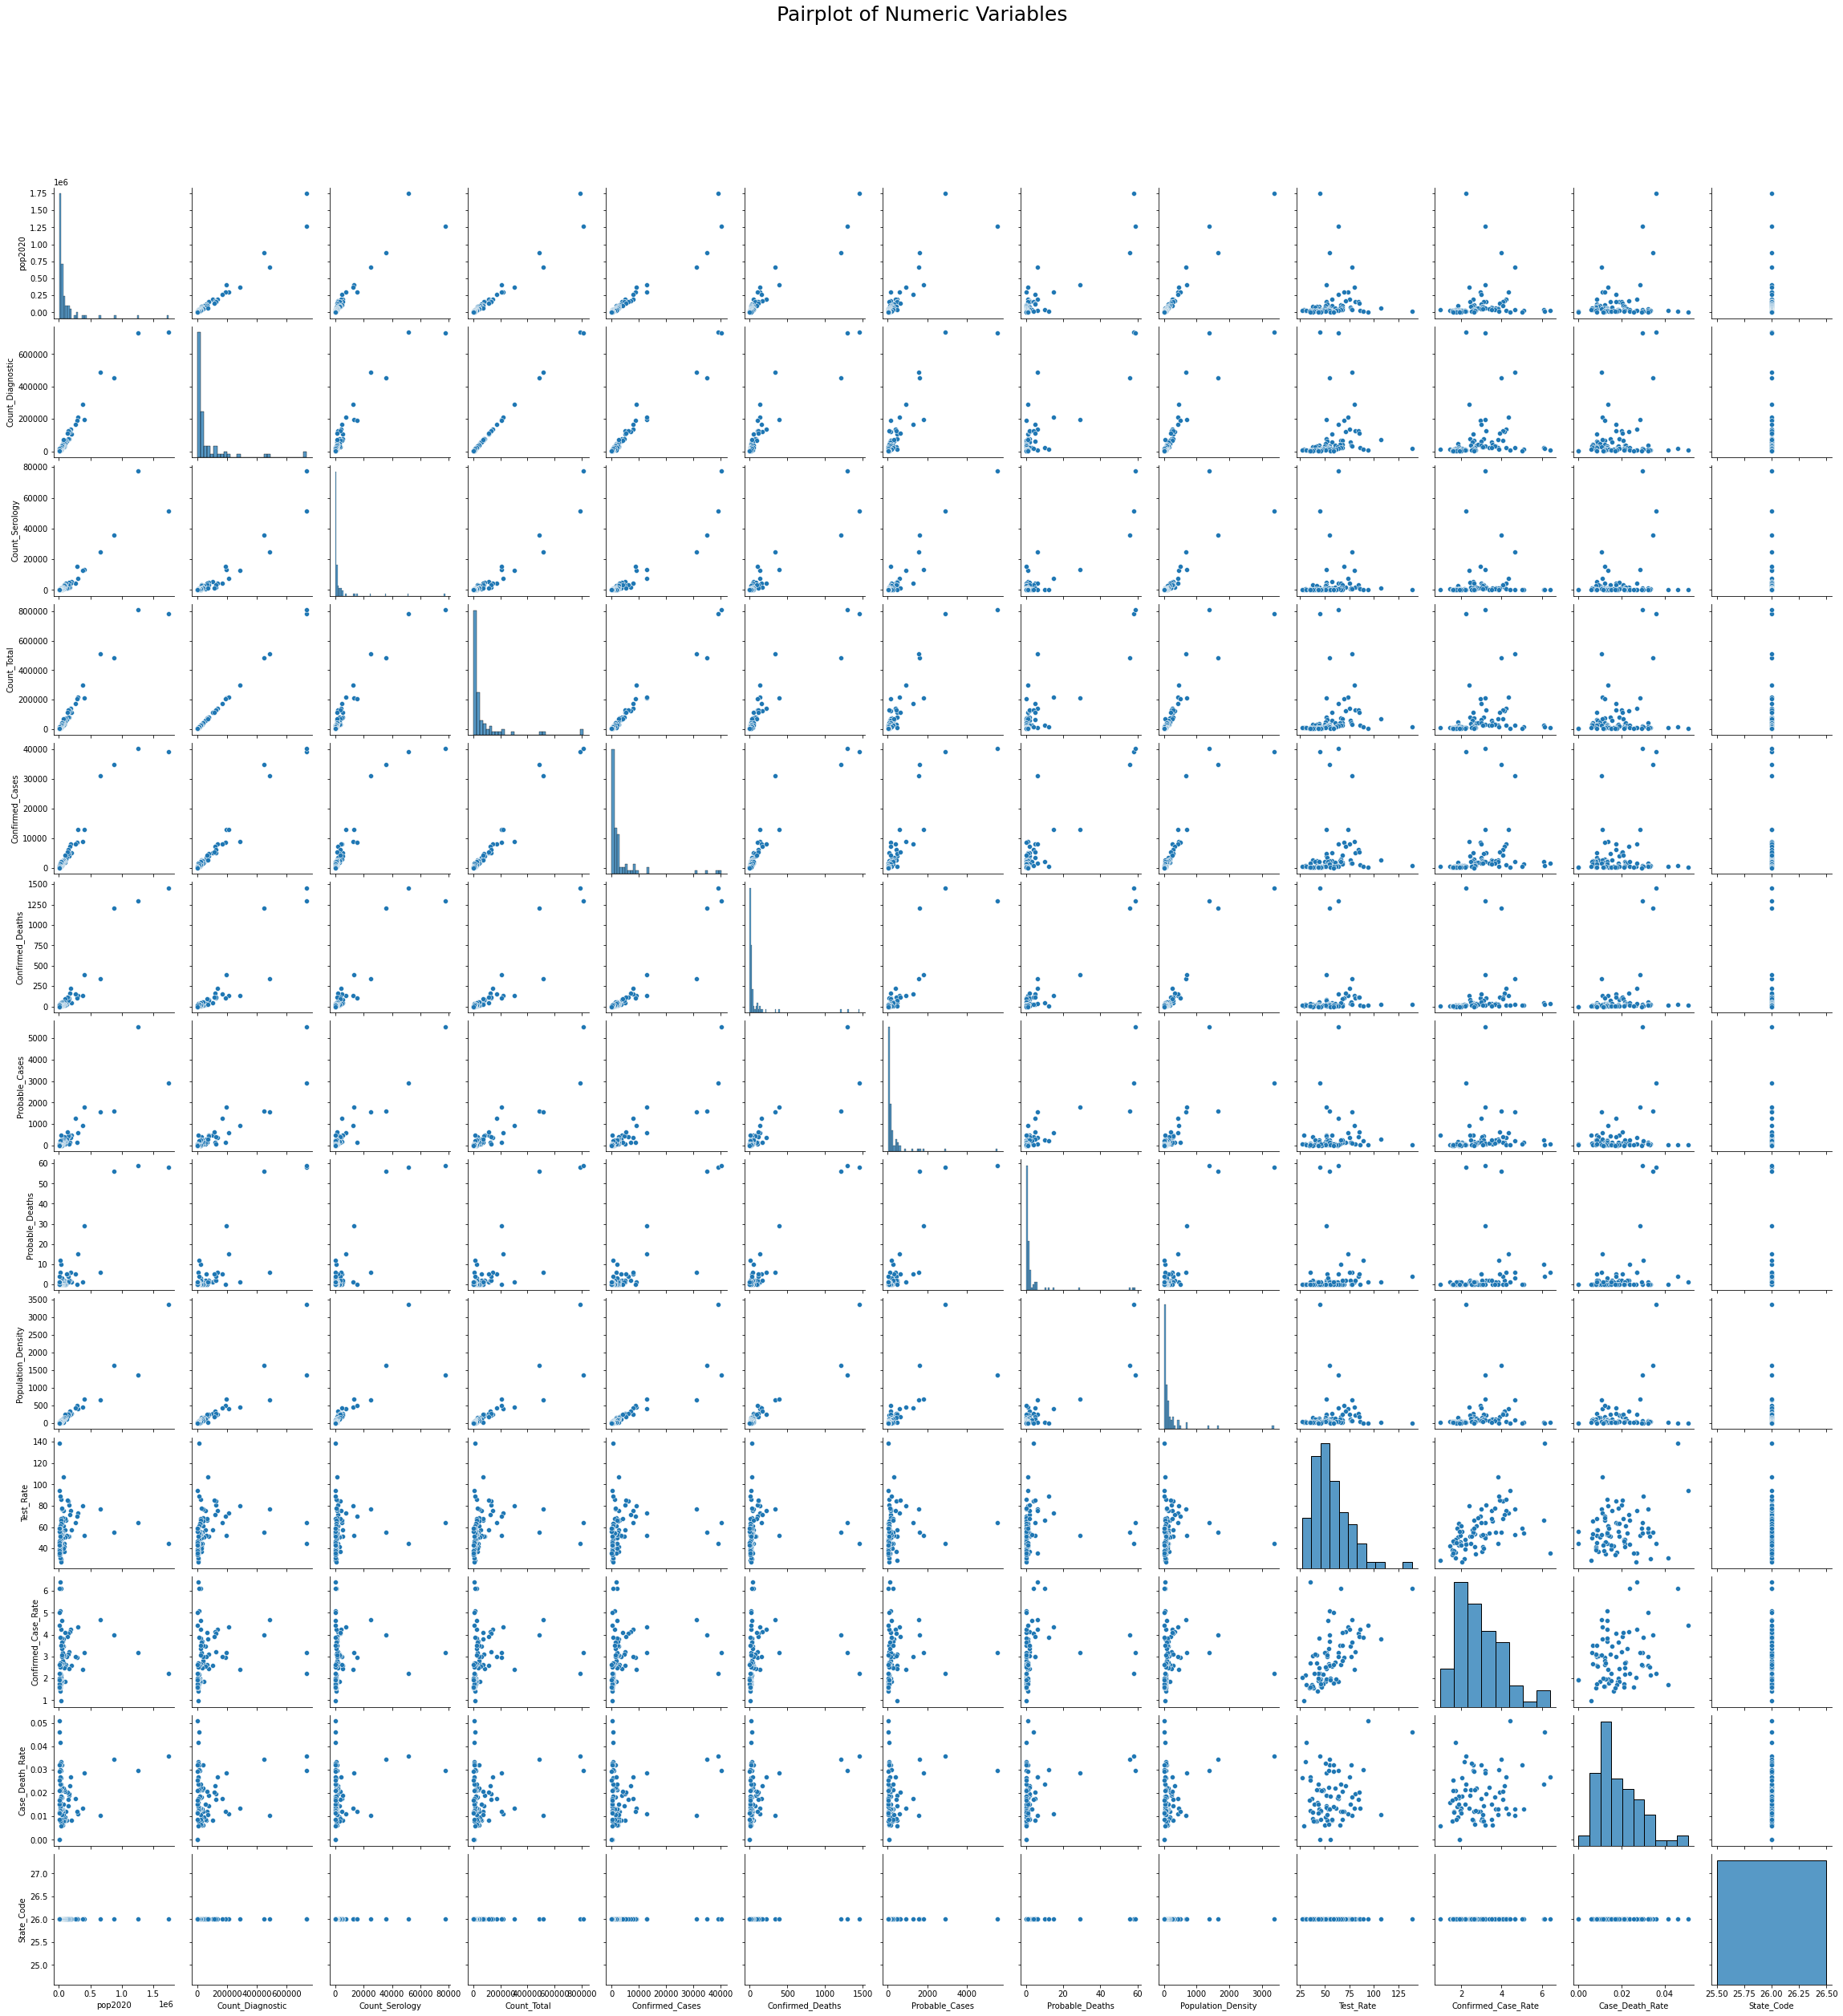

In [ ]:
fig = sns.pairplot(MergeData3).fig ;
fig.suptitle("Pairplot of Numeric Variables", y=1.08, fontsize=25);

The above pairplot gives an overview of what associations could potentially be examined between variables in the MergeData3.

#MERC Region Analysis

This analysis is performed using a static data 'snapshot' from late November using the state defined geographical "MERC Regions" (Michigan Economic Council Recovery Regions).

An important quality of the MERC regions is the population and population density of their constituent counties. It is expected that population density will impact the covid-19 indicators. The population distribution among the MERC Regions is shown below:

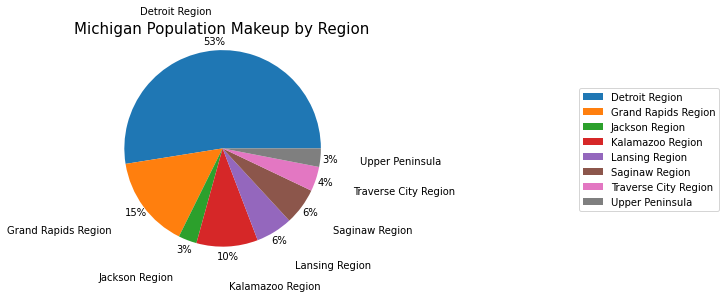

In [ ]:
fig, ax = plt.subplots()

labels = ['Detroit Region' , 'Grand Rapids Region' , 'Jackson Region' , 'Kalamazoo Region' , 'Lansing Region' , 
          'Saginaw Region' , 'Traverse City Region' , 'Upper Peninsula']
percentages = [Pct_Pop_Det , Pct_Pop_GR , Pct_Pop_Jack , Pct_Pop_Kala , Pct_Pop_Lans , Pct_Pop_Sag , 
               Pct_Pop_TC , Pct_Pop_UP]
explode=(0 , 0 , 0 , 0 , 0 , 0 , 0 , 0)

ax.pie(percentages, explode=explode, labels=labels, autopct='%1.0f%%', shadow=False, 
       startangle=0, pctdistance=1.1,labeldistance=1.4)
ax.axis('equal')

ax.set_title("Michigan Population Makeup by Region", fontsize = 15)
ax.legend(frameon=True, bbox_to_anchor=(2,0.8))
plt.show()

The Detroit Region contains over half of the state's population, followed by the Grand Rapids region at 15% of the state population. Together these two major urban regions comprise 68% of the population of the state.

The following bar chart shows the quantity of counties of three different population density bins that each MERC region contains.

The bins are 0-100 people per square mile, 100-500 people per square mile, and 500 - 10000 people per square mile. Counties of the first group are significantly rural, those of the last group are significantly urban, while those of the middle group are not significantly either.

Text(0.5, 1.0, 'Quantity of Counties of a Population Bin by MERC_Region')

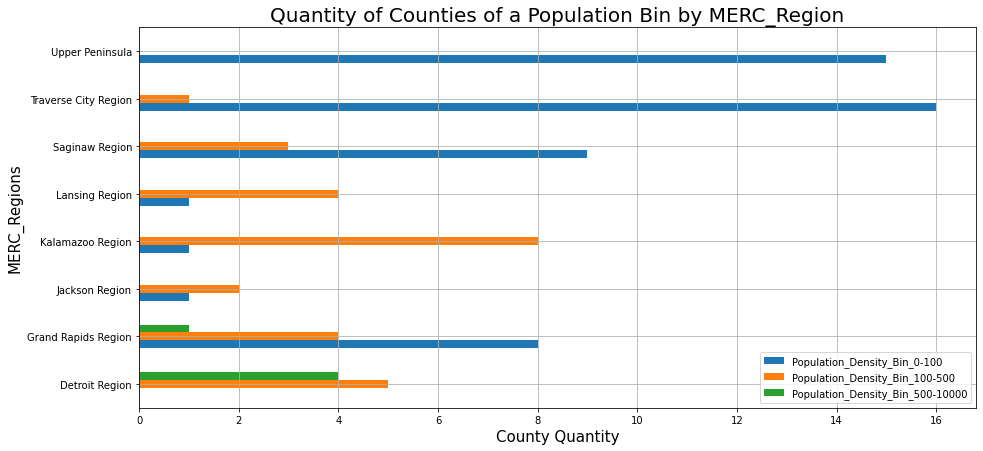

In [ ]:
#Frequency Plot showing count of population density bin counties by merc
PopDensityBinnedByMERCTemp = MergeData2.groupby(['MERC_Regions', 'Population_Density_Bins']).agg(['count'])["COUNTY"]
PopDensityBinnedByMERCTemp['Ordered'] = [1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,1,2,3]

PopDensityBin1 = PopDensityBinnedByMERCTemp.loc[PopDensityBinnedByMERCTemp['Ordered']==1]
PopDensityBin1 = PopDensityBin1.reset_index(drop=True)

PopDensityBin2 = PopDensityBinnedByMERCTemp.loc[PopDensityBinnedByMERCTemp['Ordered']==2]
PopDensityBin2 = PopDensityBin2.reset_index(drop=True)

PopDensityBin3 = PopDensityBinnedByMERCTemp.loc[PopDensityBinnedByMERCTemp['Ordered']==3]
PopDensityBin3 = PopDensityBin3.reset_index(drop=True)

#I could not figure out how to extract MERC_Region column info from the Pop Density Binned by merc temp dataframe
PopDensityBinnedByMERC = pd.DataFrame(data = {'MERC_Region':['Detroit Region', 'Grand Rapids Region', 'Jackson Region', 'Kalamazoo Region', 'Lansing Region', 'Saginaw Region', 'Traverse City Region', 'Upper Peninsula']})
PopDensityBinnedByMERC['Population_Density_Bin_0-100'] = PopDensityBin1['count']
PopDensityBinnedByMERC['Population_Density_Bin_100-500'] = PopDensityBin2['count']
PopDensityBinnedByMERC['Population_Density_Bin_500-10000'] = PopDensityBin3['count']
PopDensityBinnedByMERC.set_index(["MERC_Region"], inplace=True)

#Now for the actual plot
PopDensityBinByMERC_BarChart = PopDensityBinnedByMERC.plot.barh(figsize=(15,7),grid = True)
PopDensityBinByMERC_BarChart.set_xlabel("County Quantity",fontsize=15)
PopDensityBinByMERC_BarChart.set_ylabel("MERC_Regions",fontsize=15)
PopDensityBinByMERC_BarChart.set_title("Quantity of Counties of a Population Bin by MERC_Region",fontsize=20);


It is shown that the distribution of counties by population density is not equal among the MERC regions. This disparity reflects the population distribution disparity as shown previously.

Only two contain the highest density bin: the Grand Rapids Region and the Detroit Region. This aligns with the prior finding that these two regions also contain 68% of the population of the state.

Only one region consists entirely of the lowest density bin: Upper Peninsula. 

With this understanding of the population and population density distributions of the MERC regions we wish to know if there are any distinct trends in the covid data available. To start, below is a chart showing the Confirmed Positive Case Rate by MERC Region:

Text(0.5, 1.0, 'Confirmed Case Rate by MERC_Region')

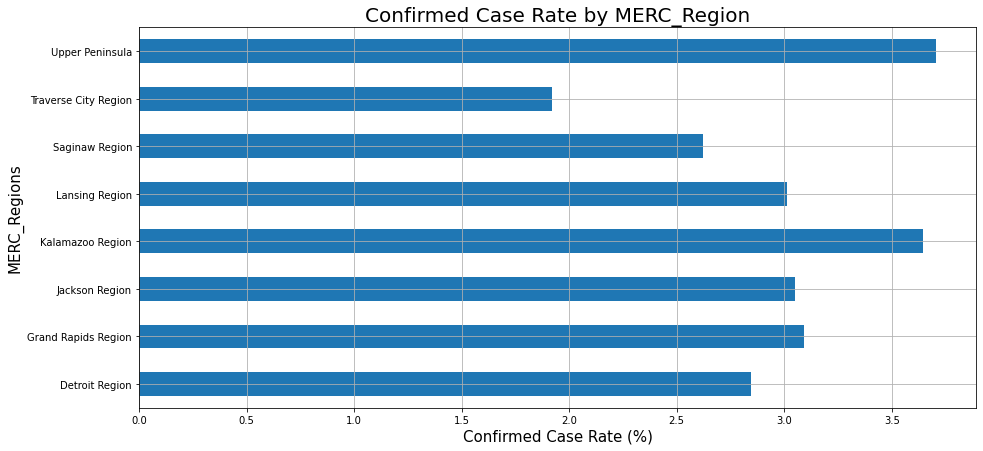

In [ ]:
ConfirmedPositiveRate_ByMERC_BarChart = MergeData2.groupby(['MERC_Regions']).mean()['Confirmed_Case_Rate'].plot.barh(figsize=(15,7),grid = True)
ConfirmedPositiveRate_ByMERC_BarChart.set_xlabel("Confirmed Case Rate (%)",fontsize=15)
ConfirmedPositiveRate_ByMERC_BarChart.set_ylabel("MERC_Regions",fontsize=15)
ConfirmedPositiveRate_ByMERC_BarChart.set_title("Confirmed Case Rate by MERC_Region",fontsize=20)

Interestingly, the Confirmed Positive Case Rate (this is the percent of tests performed that are confirmed) is noicably larger than mean for the Upper Peninsula and Kalamazoo Regions but lower than mean for the Traverse City Region.

Plotting the Confirmed Positive Rate per capita instead against the Test Rate using the MERC Regions, the following scatter plot has been produced:

Text(0.5, 1.0, 'Test Rate (Tests per capita) vs. Confirmed Positive Rate (Confirmed per capita) By MERC Region')

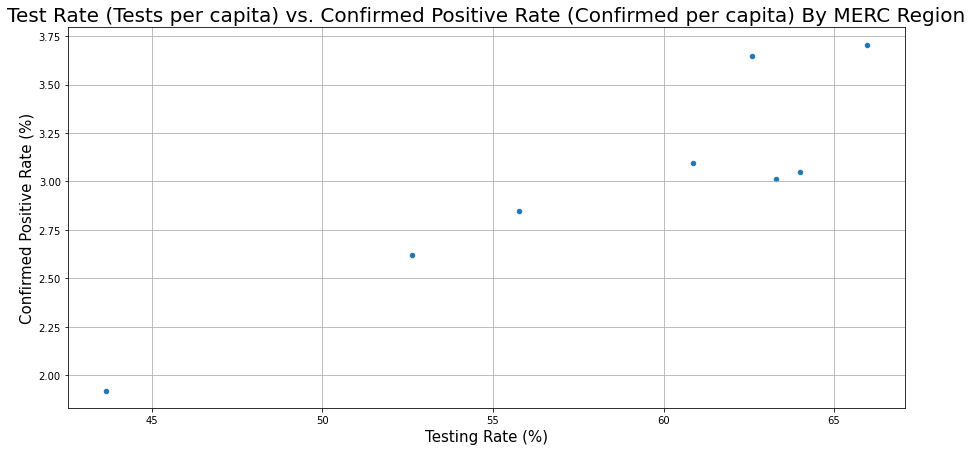

In [ ]:
TestRate_vs_ConfirmedRate_ByMERC_ScatterPlot = MergeData2.groupby(['MERC_Regions']).mean().plot.scatter("Test_Rate","Confirmed_Case_Rate",figsize=(15,7) ,grid = True)
TestRate_vs_ConfirmedRate_ByMERC_ScatterPlot.set_xlabel("Testing Rate (%)",fontsize=15)
TestRate_vs_ConfirmedRate_ByMERC_ScatterPlot.set_ylabel("Confirmed Positive Rate (%)",fontsize=15)
TestRate_vs_ConfirmedRate_ByMERC_ScatterPlot.set_title("Test Rate (Tests per capita) vs. Confirmed Positive Rate (Confirmed per capita) By MERC Region",fontsize=20)

There is a noticable correlation between the Confirmed Positive Rate and the Testing Rate for a given MERC Region with some outliers.

Of interest is the effect of population density. To examine what relationship that might exist between this and some of the covid related metrics, first up is a plot of Population Density vs. the Confirmed Positive Rate by MERC.

Text(0.5, 1.0, 'Population_Density (People per square mile) vs. Confirmed Positive Rate (Confirmed per capita) By MERC Region')

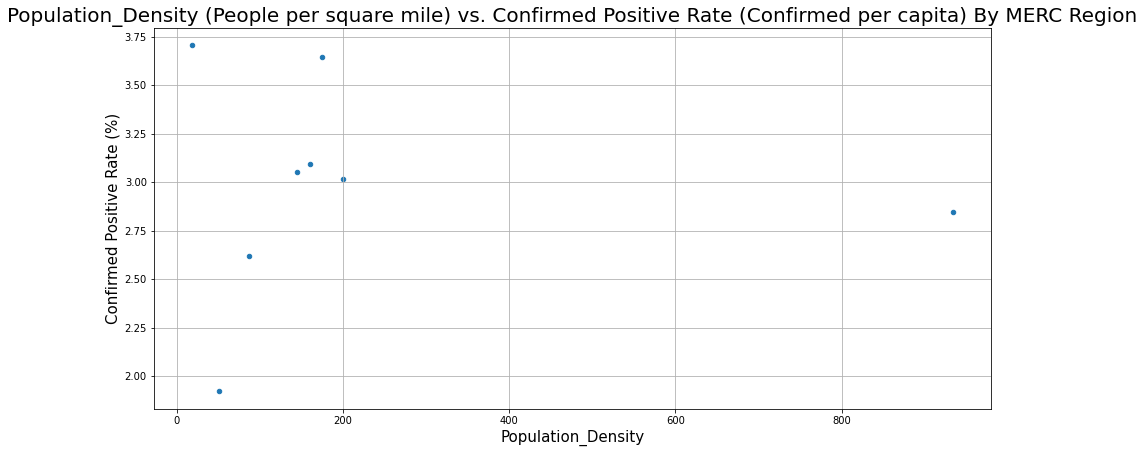

In [ ]:
PopDensity_vs_ConfirmedRate_ByMERC_ScatterPlot = MergeData2.groupby(['MERC_Regions']).mean().plot.scatter("Population_Density","Confirmed_Case_Rate", figsize=(15,7),grid = True)
PopDensity_vs_ConfirmedRate_ByMERC_ScatterPlot.set_xlabel("Population_Density",fontsize=15)
PopDensity_vs_ConfirmedRate_ByMERC_ScatterPlot.set_ylabel("Confirmed Positive Rate (%)",fontsize=15)
PopDensity_vs_ConfirmedRate_ByMERC_ScatterPlot.set_title("Population_Density (People per square mile) vs. Confirmed Positive Rate (Confirmed per capita) By MERC Region",fontsize=20)

There does not appear to be a significant correlation between population density and the confirmed positive rate from this plot. Is there however a trend between Death Rate and Population Density?

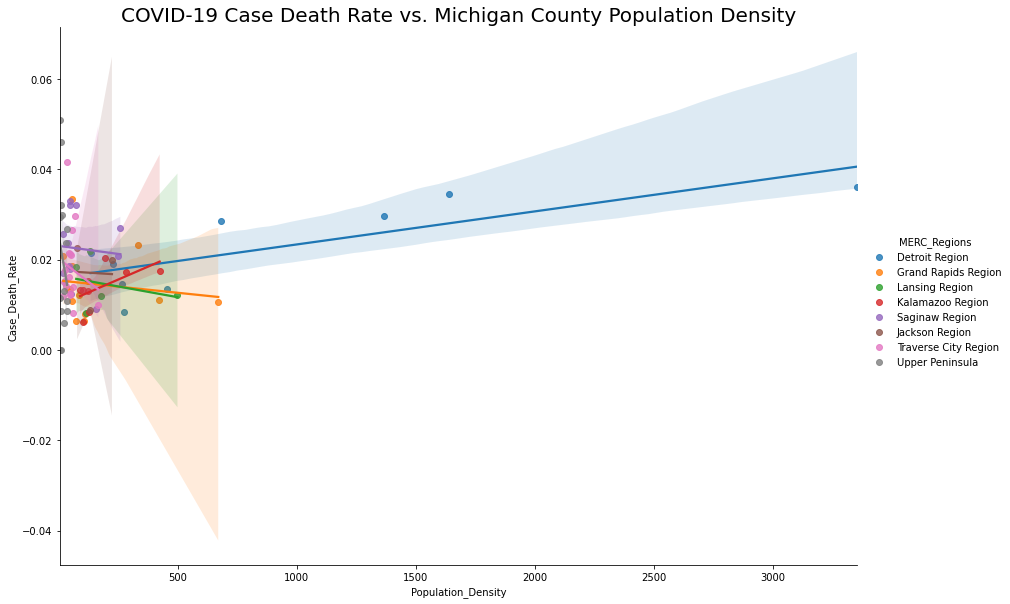

In [ ]:
sns.lmplot(x = 'Population_Density' , y = 'Case_Death_Rate' , data = MergeData3 , hue = 'MERC_Regions', height = 8 , aspect = 1.5)
ax = plt.gca()
ax.set_title("COVID-19 Case Death Rate vs. Michigan County Population Density", fontsize = 20)
plt.show()

When the data is taken county by county (as shown by the individual points above) there does not appear to be a clear relationship between Population Density and Death Rate except perhaps that the death rate becomes 'steady' for those counties with higher population densities, as seen by the narrowing of the vertical span of the data points moving from left to right across the plot.

When the data for each MERC Region is separated as indicated by the colors there do appear to be trends of interest between Population Density and Death Rate. These do vary from positive to negative trends for the various MERC Regions, however.

Proportionally, the Deaths by MERC Region are illustrated below:

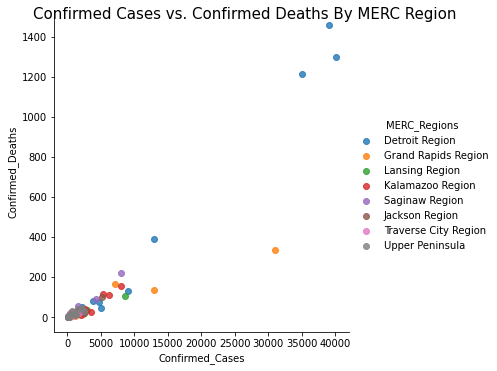

In [ ]:
fig = sns.lmplot(x='Confirmed_Cases', y='Confirmed_Deaths', hue='MERC_Regions', fit_reg=False, data=MergeData3).fig
fig.suptitle("Confirmed Cases vs. Confirmed Deaths By MERC Region", fontsize=15);

The above multivariate plot shows the relationship between confirmed cases and confirmed deaths based on MERC regions.

It is noticed that counties within the Detroit region have higher cases and deaths while and counties within the Grand Rapids region have less deaths although one county show a high number of cases. This could be due to the difference in population densities in each county of the same region.

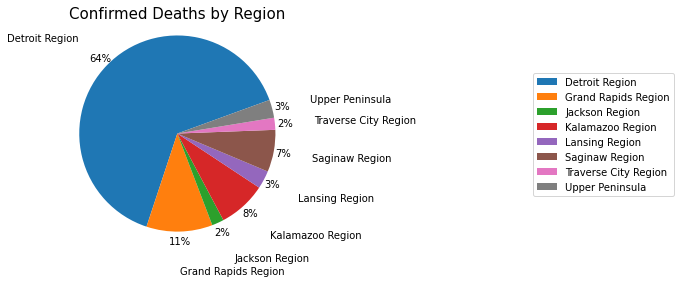

In [ ]:
fig, ax = plt.subplots()

labels = ['Detroit Region' , 'Grand Rapids Region' , 'Jackson Region' , 'Kalamazoo Region' , 'Lansing Region' , 
          'Saginaw Region' , 'Traverse City Region' , 'Upper Peninsula']
percentages = [Pct_ConfD_Det , Pct_ConfD_GR , Pct_ConfD_Jack , Pct_ConfD_Kala , Pct_ConfD_Lans , Pct_ConfD_Sag , 
               Pct_ConfD_TC , Pct_ConfD_UP]
explode=(0 , 0 , 0 , 0 , 0 , 0 , 0 , 0)

ax.pie(percentages, explode=explode, labels=labels, autopct='%1.0f%%', shadow=False, 
       startangle=20, pctdistance=1.1,labeldistance=1.4)
ax.axis('equal')

ax.set_title("Confirmed Deaths by Region", fontsize = 15)
ax.legend(frameon=True, bbox_to_anchor=(2,0.8))
plt.show()

Similar to the Population Pie Chart at the start of the section, the MERC Regions with larger populations also have the most deaths, although it is apparent that the Detroit Region has a larger share of the deaths proportional to their share of the total population of the state.

#County Level Analysis

This analysis is performed using a static data 'snapshot' from late November using counties.

In [ ]:
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
      print(type(response))
      counties = json.load(response)

<class 'http.client.HTTPResponse'>


In [ ]:
fig = px.choropleth(MergeData3, geojson=counties, locations='FIPS', color='Case_Death_Rate',
                             color_continuous_scale="Viridis",
                             range_color=(0, 0.05),
                             scope="usa",
                             labels={'Case_Death_Rate':'case death rate'})

fig.update_layout(title_text = 'COVID-19 Case Death Rate by Michigan County')#margin={"r":0,"t":0,"l":0,"b":0}, title_text = 'COVID-19 Case Death Rate by Michigan County')
fig.show()

In [ ]:
fig = px.choropleth(MergeData3, geojson=counties, locations='FIPS', color='Population_Density',
                             color_continuous_scale="Viridis",
                             range_color=(0, 500),
                             scope="usa",
                             labels={'Population_Density':'population density'})

fig.update_layout(title_text = 'Population Density by Michigan County')#margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

From the two maps above, there appears to be a correlation between population density and case death rate, especially in the southeast part of the state. The plot graph from the MERC Region analysis shows that correlation. Something interesting to note: there appears to be a slight NEGATIVE correlation between case death rate and population density in the Lansing, Grand Rapids, and Saginaw areas. This could be due to the surrounding counties of those metro areas are more rural than the surrounding counties of Detroit, which could explain why there's a negative skew.

Exploring this further, the data has been plotted below in a scatter plot of Population Density vs. Case Death Rate

Text(0.5, 1.0, 'Population_Density (People per square mile) vs. Death Rate')

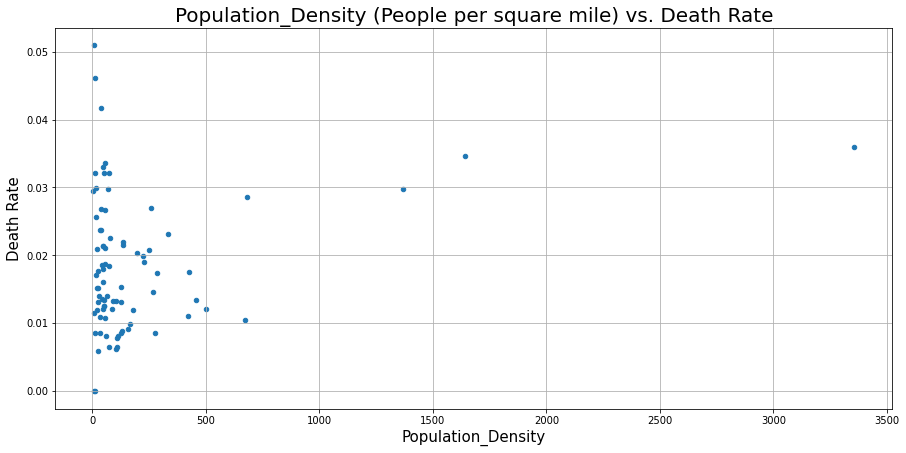

In [ ]:
PopDensity_vs_DeathdRate_ScatterPlot = MergeData2.plot.scatter("Population_Density","Case_Death_Rate", figsize=(15,7),grid = True)
PopDensity_vs_DeathdRate_ScatterPlot.set_xlabel("Population_Density",fontsize=15)
PopDensity_vs_DeathdRate_ScatterPlot.set_ylabel("Death Rate",fontsize=15)
PopDensity_vs_DeathdRate_ScatterPlot.set_title("Population_Density (People per square mile) vs. Death Rate",fontsize=20)

The possible relationship between Population Density and Case Death Rate appears here as well. The box plot below reveals the statistical spread in Case Death Rate for various Population Density bins (as previously defined in the MERC section).

Text(0.5, 1.0, 'Case Death Rate by County Population Bin')

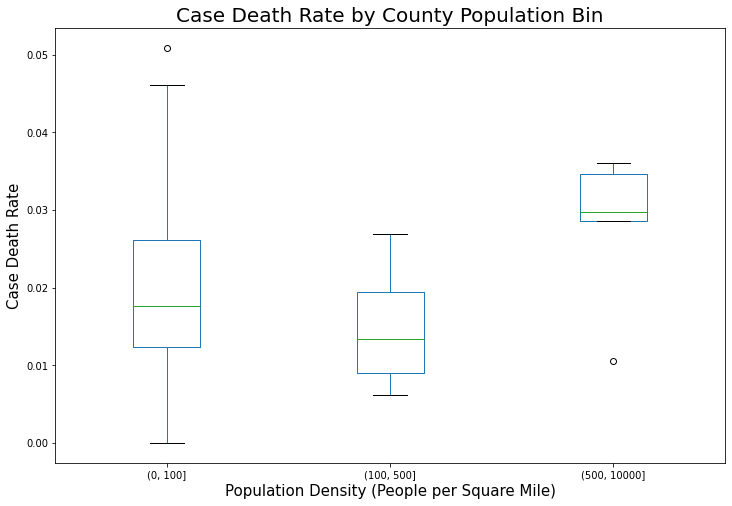

In [ ]:
bpInterval1 = pd.Interval(left = 0, right = 100)
bpInterval2 = pd.Interval(left = 100, right = 500)
bpInterval3 = pd.Interval(left = 500, right = 10000)

boxPlotdf = pd.DataFrame(columns = [bpInterval1,bpInterval2,bpInterval3])

#crude method of binning the data
boxPlotdf1 = MergeData2.loc[(MergeData2["Population_Density_Bins"] == bpInterval1)] #10
boxPlotdf1 = boxPlotdf1.reset_index(drop=True)

boxPlotdf2 = MergeData2.loc[(MergeData2["Population_Density_Bins"] == bpInterval2)]
boxPlotdf2 = boxPlotdf2.reset_index(drop=True)

boxPlotdf3 = MergeData2.loc[(MergeData2["Population_Density_Bins"] == bpInterval3)]
boxPlotdf3 = boxPlotdf3.reset_index(drop=True)

boxPlotdf[bpInterval1] = boxPlotdf1["Case_Death_Rate"]
boxPlotdf[bpInterval2] = boxPlotdf2["Case_Death_Rate"]
boxPlotdf[bpInterval3] = boxPlotdf3["Case_Death_Rate"]


boxplot = boxPlotdf.plot.box(figsize = [12,8]) #21 PLOT 4
boxplot.set_xlabel("Population Density (People per Square Mile)",fontsize=15)
boxplot.set_ylabel("Case Death Rate",fontsize=15)
boxplot.set_title("Case Death Rate by County Population Bin",fontsize=20)


As can be seen from this simple side-by-side comparison, there is clear greater variation in the Case Death Rate with decreasing population density. Interestingly, while interquartile range of the densist counties is highest, it is lowest not for the lowest population density bin but instead for the medium population density bin. The span of the highest population density bin is in fact completely contained within the range of the lowest density bin. 

**COVID-19 Cases by County - Mean/Median Analysis**

This analysis uses the time series COVID-19 cases dataset assigned in Lab 1, which is updated daily. In this analysis, COVID-19 cases in each Michigan county are taken from present day, and compared with each other, the mean, and median. 

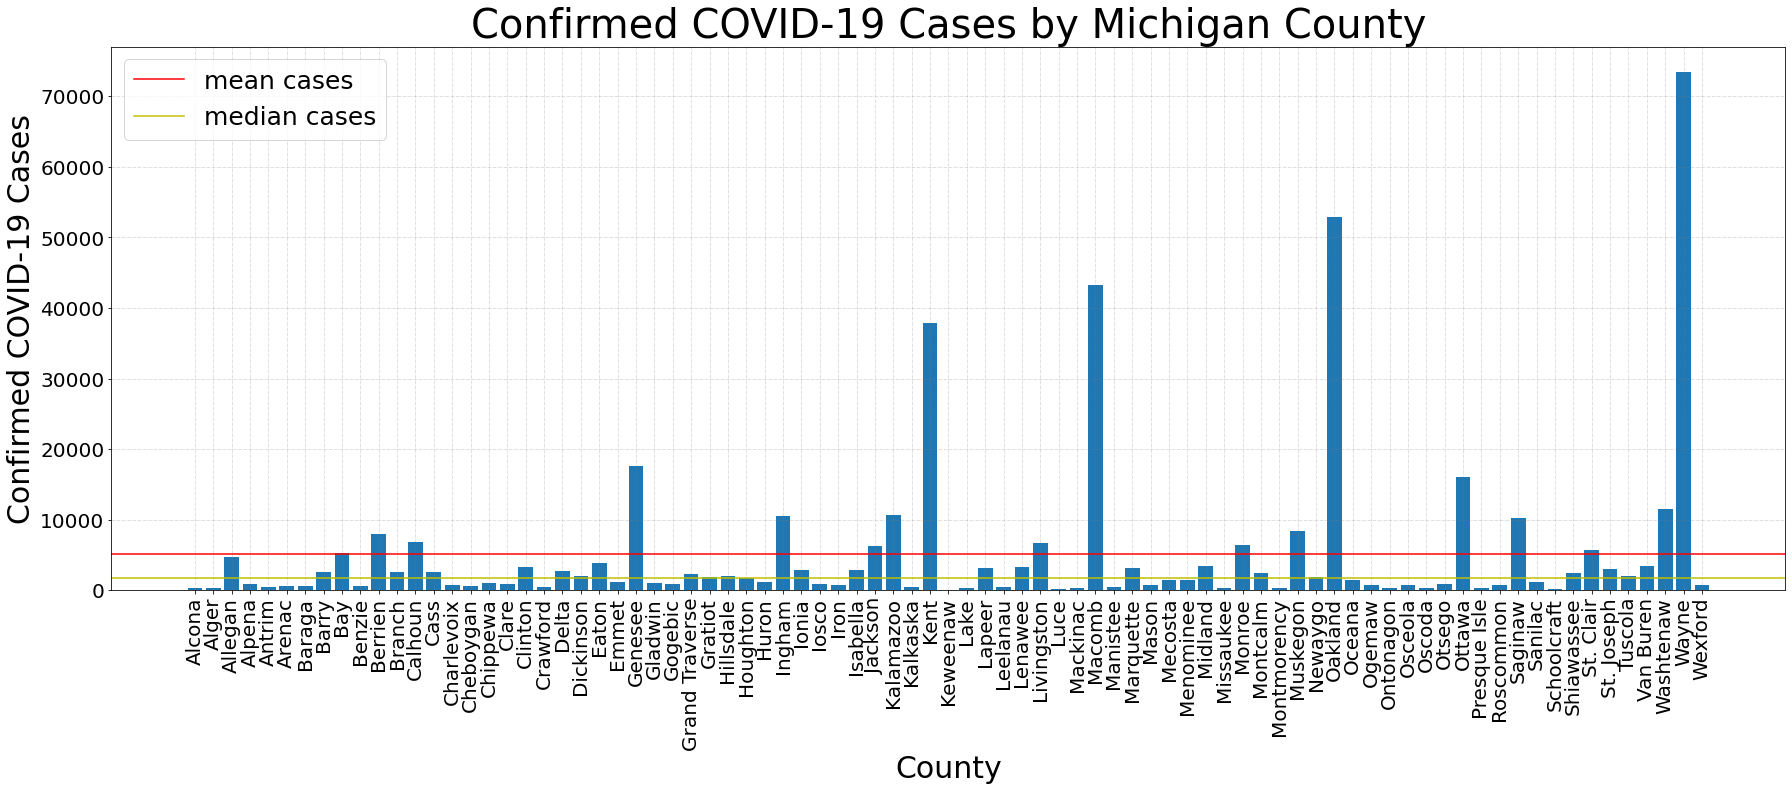

In [ ]:
covid_confirmed_cases = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv") #confimed cases time series data
covid_confirmed_cases.drop(['Combined_Key','FIPS','UID','iso2',"iso3", "code3", "Country_Region", 'Lat', 'Long_'] , axis=1 , inplace=True) #3
covid_confirmed_cases.rename(columns={"Admin2":"County","Province_State":"State"},inplace=True) #4
covid_confirmed_cases = covid_confirmed_cases[(covid_confirmed_cases.State == "Michigan")]
covid_confirmed_cases.drop([1304, 1336, 1352, 1362 ] , axis=0 , inplace=True)

covid_confirmed_cases_with_total = pd.DataFrame(covid_confirmed_cases)
covid_confirmed_cases_with_total.loc['Total Cases']= covid_confirmed_cases_with_total.sum(numeric_only=True, axis=0)
covid_confirmed_cases_with_total["County"]= covid_confirmed_cases_with_total["County"].astype(str) 


# creating the bar plot 
fig = plt.figure(figsize = (30, 10)) 
plt.bar(covid_confirmed_cases["County"],covid_confirmed_cases["12/9/20"])
  
plt.grid(b = True, color ='grey', 
        linestyle ='-.', linewidth = 0.5, 
        alpha = 0.5)   
plt.xlabel("County", fontsize = 30)
plt.xticks(rotation='vertical', fontsize = 20) 
plt.yticks(fontsize = 20)
plt.ylabel("Confirmed COVID-19 Cases", fontsize = 30)
plt.title("Confirmed COVID-19 Cases by Michigan County", fontsize = 40)
plt.axhline(y= covid_confirmed_cases["12/9/20"].mean(), color='r', label = 'mean cases')	
plt.axhline(y= covid_confirmed_cases["12/9/20"].median(), color='y', label = 'median cases')
plt.legend(fontsize = 25)
plt.show() 
#covid_confirmed_cases["12/9/20"].mean()
#covid_confirmed_cases["12/9/20"].median()

The counties with the most confirmed COVID-19 cases are: 
1. Wayne
2. Oakland
3. Macomb
4. Kent
5. Genesee

Perhaps not surprising, the five counties with the most confirmed cases are also the counties with the highest population and population density. An interesting takeaway when looking at population densities and number of cases is although Genesee county has a higher population density than Kent county, Genesee has half the number of cases compared to Kent.

The mean of the data is 5186.20, while the median of the data is 1783 cases. Due to the skewed distribution of cases, the median value gives a more realistic picture of the data.

**COVID-19 Deaths by County - Mean/Median Analysis**
This analysis uses the time series COVID-19 deaths dataset assigned in Lab 1, which is updated daily. In this analysis, COVID-19 deaths in each Michigan county are taken from present day, and compared with each other, the mean, and median. 

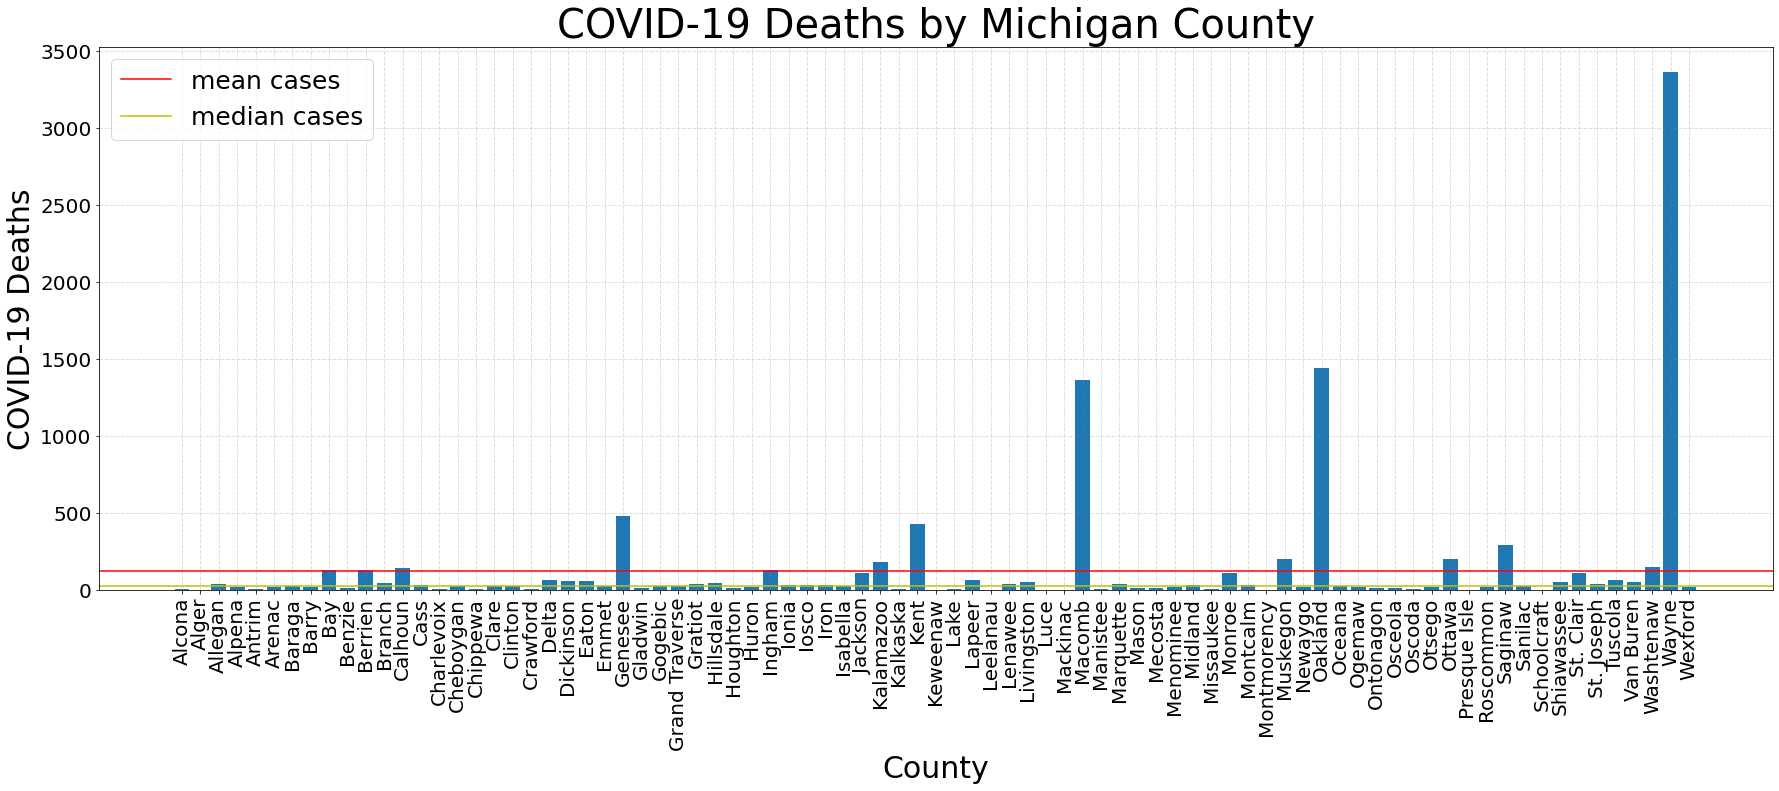

In [ ]:
covid_deaths = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv")
covid_deaths.drop(['Combined_Key','FIPS','UID','iso2',"iso3", "code3", "Country_Region", 'Lat', 'Long_','Population'] , axis=1 , inplace=True) #3
covid_deaths.rename(columns={"Admin2":"County","Province_State":"State"},inplace=True)
covid_deaths = covid_deaths[(covid_deaths.State == "Michigan")]
covid_deaths.drop([1304, 1336, 1352, 1362 ] , axis=0 , inplace=True)

covid_deaths_with_total = pd.DataFrame(covid_deaths)
covid_deaths_with_total.loc['Total Deaths']= covid_deaths_with_total.sum(numeric_only=True, axis=0)
covid_deaths_with_total["County"]= covid_deaths_with_total["County"].astype(str) 

fig = plt.figure(figsize = (30, 10)) 
  
# creating the bar plot 
plt.bar(covid_deaths["County"],covid_deaths["12/9/20"])
  
plt.grid(b = True, color ='grey', 
        linestyle ='-.', linewidth = 0.5, 
        alpha = 0.5)   
plt.xlabel("County", fontsize = 30)
plt.xticks(rotation='vertical', fontsize = 20) 
plt.yticks(fontsize = 20)
plt.ylabel("COVID-19 Deaths", fontsize = 30)
plt.title("COVID-19 Deaths by Michigan County", fontsize = 40)
plt.axhline(y= covid_deaths["12/9/20"].mean(), color='r', label = 'mean cases')	
plt.axhline(y= covid_deaths["12/9/20"].median(), color='y', label = 'median cases')
plt.legend(fontsize = 25)
plt.show() 
#covid_deaths["12/9/20"].mean()
#covid_deaths["12/9/20"].median()

The counties with the most confirmed COVID-19 deaths are: 
1. Wayne
2. Oakland
3. Macomb
4. Genesee
5. Kent


Unsurprisingly, the five counties with the highest death totals are also the counties with the most confirmed cases, highest population, and highest population densities.

Observing the data reveals that Kent county has slightly less COVID-19 related deaths than Genesee county despite having more than double the amount the cases. Population density is a probable factor as Kent county has a lower population density than Genesee, but a deeper look into Genesse and Kent's healthcare systems could reveal more about this difference.

The mean of the data is 127.61, while the median of the data is 27 deaths. Due to the skewed distribution of cases, the median value gives a more realistic picture of the data.

#Time Series Analysis

**COVID-19 Cases - Time Series Analysis**

This analysis uses the time series COVID-19 cases dataset assigned in Lab 1, which is updated daily. In this analysis, statewide COVID-19 cases in Michigan are tracked from 1-22-20 to present day, with markers added to denote when stay at home measures were implemented in Michigan. 

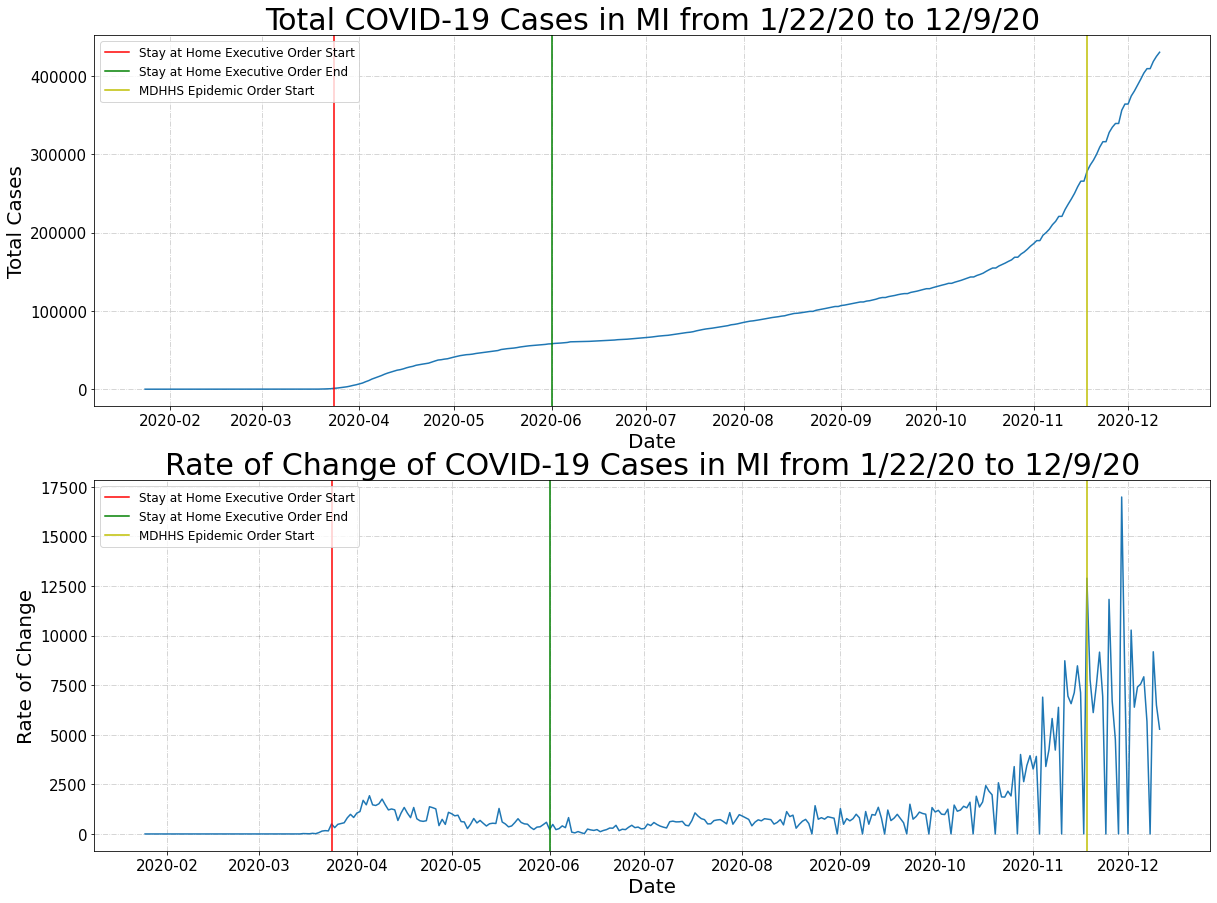

In [ ]:
covid_confirmed_cases_with_total_transposed = pd.DataFrame(covid_confirmed_cases_with_total.loc['Total Cases'].T)
covid_confirmed_cases_with_total_transposed['Date'] = pd.date_range(start='1/22/2020', periods=len(covid_confirmed_cases_with_total_transposed), freq='D')
covid_confirmed_cases_with_total_transposed.drop(['County','State'] , axis=0 , inplace=True)
covid_confirmed_cases_with_total_transposed['Rate of Change'] = covid_confirmed_cases_with_total_transposed['Total Cases'].diff()

fig = plt.figure(figsize = (20, 15)) 
plt.xticks(fontsize = 35)
plt.yticks(fontsize = 35)
plt.axvline(dt.datetime(2020, 3, 24), color='r')
plt.axvline(dt.datetime(2020, 6, 1), color='g')
plt.axvline(dt.datetime(2020, 11, 18), color='y')
plt.subplot(2, 1, 1)
plt.grid(b = True, color ='black', 
        linestyle ='-.', linewidth = 0.8, 
        alpha = 0.2)  
plt.xticks(fontsize = 15) 
plt.yticks(fontsize = 15) 
plt.title("Total COVID-19 Cases in MI from 1/22/20 to 12/9/20", fontsize = 30)
plt.xlabel("Date", fontsize = 20) 
plt.ylabel("Total Cases", fontsize = 20) 
plt.plot(covid_confirmed_cases_with_total_transposed['Date'],covid_confirmed_cases_with_total_transposed['Total Cases'])
plt.axvline(dt.datetime(2020, 3, 24), color='r', label = 'Stay at Home Executive Order Start')
plt.axvline(dt.datetime(2020, 6, 1), color='g', label = 'Stay at Home Executive Order End')
plt.axvline(dt.datetime(2020, 11, 18), color='y', label = 'MDHHS Epidemic Order Start')
plt.legend(fontsize = 12)
plt.subplot(2, 1, 2)
plt.grid(b = True, color ='black', 
        linestyle ='-.', linewidth = 0.8, 
        alpha = 0.2)  
plt.title("Rate of Change of COVID-19 Cases in MI from 1/22/20 to 12/9/20", fontsize = 30)
plt.xticks(fontsize = 15) 
plt.yticks(fontsize = 15) 
plt.xlabel("Date", fontsize = 20) 
plt.ylabel("Rate of Change", fontsize = 20) 
plt.plot(covid_confirmed_cases_with_total_transposed['Date'],covid_confirmed_cases_with_total_transposed['Rate of Change'] )
plt.axvline(dt.datetime(2020, 3, 24), color='r', label = 'Stay at Home Executive Order Start')
plt.axvline(dt.datetime(2020, 6, 1), color='g', label = 'Stay at Home Executive Order End')
plt.axvline(dt.datetime(2020, 11, 18), color='y', label = 'MDHHS Epidemic Order Start')
plt.legend(fontsize = 12)
#covid_confirmed_cases_with_total_transposed.tail()

Cases at executive order start: 1,936

Cases at executive order end:  58,701 -- increase of 56,765 (2932.08%%) from start of executive order (69 days)

Cases at epidemic order start: 292,553 -- increase of 233,852 (398.38%) from end of executive order (170 days)

12-9-20 cases: 430,455 -- increase of 137,902 (47.14%) from start of epidemic order (21 days)

Examining the Rate of Change plot, the rate of change per day has increased steadily since the end of the executive stay at home orders. It can be clearly observed that a significant increase in the rate of change of cases begins in November, as rate of change increased by approximately 5-7.5x when compared to June.

**COVID-19 Deaths - Time Series Analysis**

This analysis uses the time series COVID-19 deaths dataset assigned in Lab 1, which is updated daily. In this analysis, statewide COVID-19 deaths in Michigan are tracked from 1-22-20 to present day, with markers added to denote when stay at home measures were implemented in Michigan. 

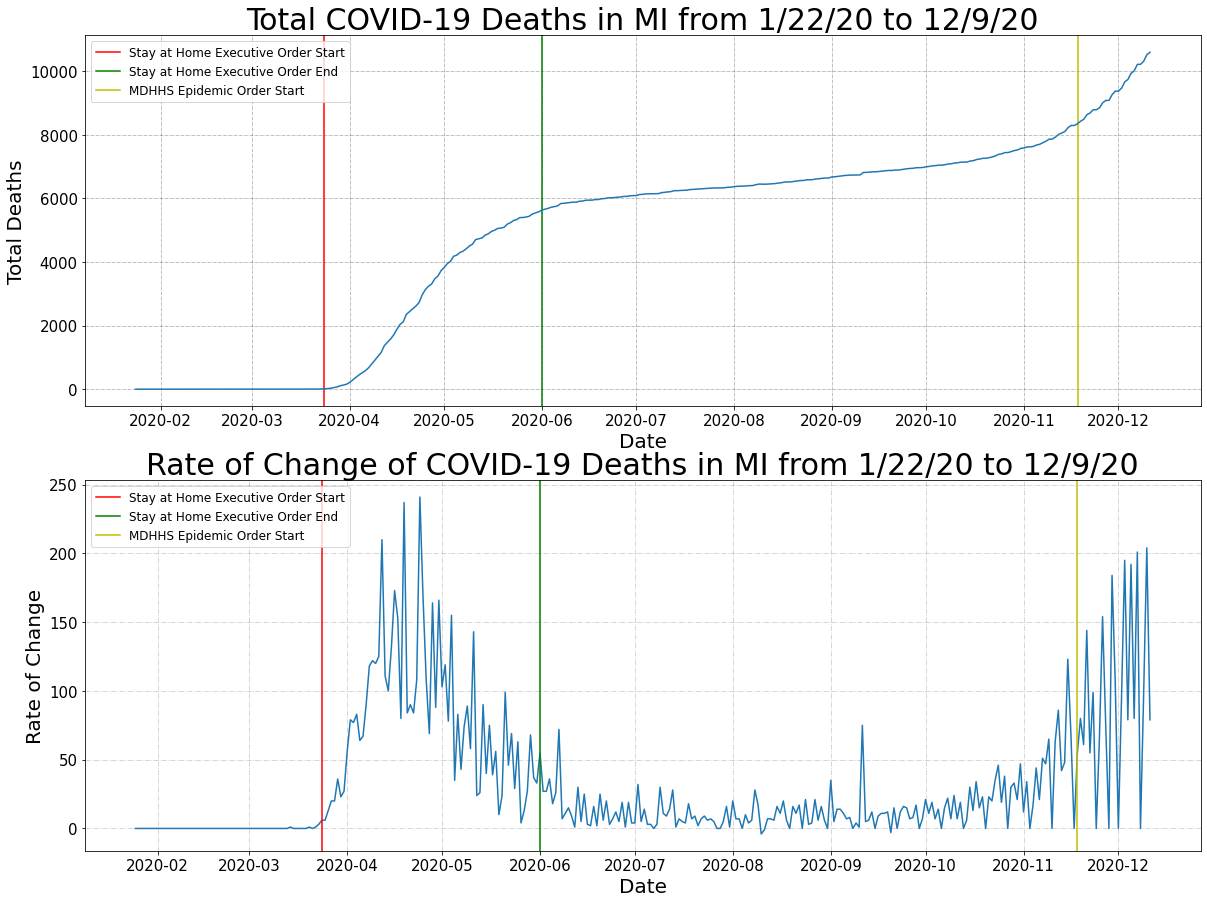

In [ ]:
covid_deaths_with_total_transposed = pd.DataFrame(covid_deaths_with_total.loc['Total Deaths'].T)
covid_deaths_with_total_transposed['Date'] = pd.date_range(start='1/22/2020', periods=len(covid_deaths_with_total_transposed), freq='D')
covid_deaths_with_total_transposed.drop(['County','State'] , axis=0 , inplace=True)
covid_deaths_with_total_transposed['Rate of Change'] = covid_deaths_with_total_transposed['Total Deaths'].diff()



fig = plt.figure(figsize = (20, 15))
plt.subplot(2, 1, 1)
plt.grid(b = True, color ='black', 
        linestyle ='-.', linewidth = 0.5, 
        alpha = 0.5)   

plt.xlabel("Date", fontsize = 20) 
plt.ylabel("Total Deaths", fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("Total COVID-19 Deaths in MI from 1/22/20 to 12/9/20", fontsize = 30) 
plt.axvline(dt.datetime(2020, 3, 24), color='r', label = 'Stay at Home Executive Order Start')
plt.axvline(dt.datetime(2020, 6, 1), color='g', label = 'Stay at Home Executive Order End')
plt.axvline(dt.datetime(2020, 11, 18), color='y', label = 'MDHHS Epidemic Order Start')
plt.plot(covid_deaths_with_total_transposed['Date'],covid_deaths_with_total_transposed['Total Deaths'] )
plt.legend(fontsize = 12)
plt.subplot(2, 1, 2)
plt.grid(b = True, color ='black', 
        linestyle ='-.', linewidth = 0.8, 
        alpha = 0.2)  
plt.title("Rate of Change of COVID-19 Deaths in MI from 1/22/20 to 12/9/20", fontsize = 30)
plt.xlabel("Date", fontsize = 20) 
plt.ylabel("Rate of Change", fontsize = 20) 
plt.plot(covid_deaths_with_total_transposed['Date'],covid_deaths_with_total_transposed['Rate of Change'] )
plt.axvline(dt.datetime(2020, 3, 24), color='r', label = 'Stay at Home Executive Order Start')
plt.axvline(dt.datetime(2020, 6, 1), color='g', label = 'Stay at Home Executive Order End')
plt.axvline(dt.datetime(2020, 11, 18), color='y', label = 'MDHHS Epidemic Order Start')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(loc = 'upper left', fontsize = 12)
#covid_deaths_with_total_transposed.tail()

Deaths at executive order start: 31

Deaths at executive order end: 5,685 -- increase of 5,654 (18238.70%) from start of executive order (69 days)

Deaths at epidemic order start: 8,486 -- increase of 2,801 (49.27%) from end of executive order (170 days)

12-9-20 deaths: 10,592 -- increase of 2,106 (24.82%) from start of epidemic order (21 days)

Examining the Rate of Change plot, the rate of change per day has increased steadily since the end of the executive stay at home orders. It can be clearly observed that a fast, significant increase in the rate of change of deaths began in April, peaking in mid-April, declined throughout the remainder of spring, and stayed relatively level during the summer months. The rate of change starts to climb in October at an increasing rate until present day, where the rate of change is approaching heights similar to the peaks seen early in the pandemic.

**Unemployment Analysis**

This analysis utilizes Michigan and US unemployment data from data.michigan.gov to reveal how COVID-19 impacted the labor force in MI and nationwide.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



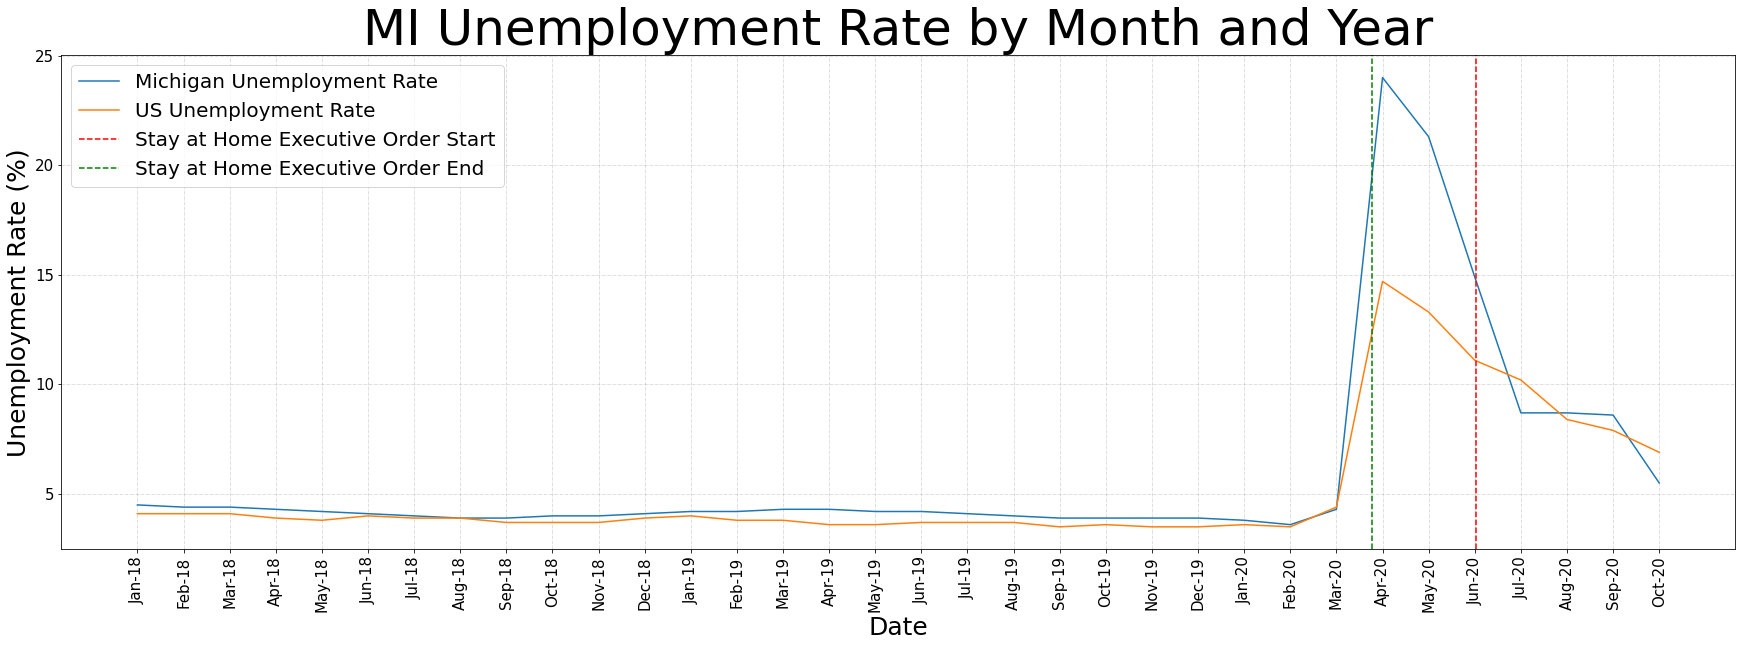

In [ ]:
unemployment_data = pd.read_csv(url_2)
unemployment_data.drop(columns = ['Rank', 'Highlights', 'Calendar Date'],axis=1 , inplace=True)
unemployment_data.drop(unemployment_data.index[0:504],axis=0 , inplace=True)

fig = plt.figure(figsize = (30, 20)) 
plt.subplot(2, 1, 1)
plt.plot(unemployment_data["Date"],unemployment_data["Unemployment_Rate_MI"]*100, label = 'Michigan Unemployment Rate')
plt.subplot(2, 1, 1)
plt.plot(unemployment_data["Date"],unemployment_data["Unemployment_Rate_US"]*100, label = 'US Unemployment Rate')

plt.grid(b = True, color ='grey', 
        linestyle ='-.', linewidth = 0.5, 
        alpha = 0.5)   
plt.xlabel("Date", fontsize = 25)
plt.xticks(rotation='vertical', fontsize = 15) 
plt.yticks(fontsize = 15) 
plt.ylabel("Unemployment Rate (%)", fontsize = 25)
plt.axvline(x=29.03333, color='r', linestyle ='--', label = 'Stay at Home Executive Order Start')
plt.axvline(x=26.77, color='g', linestyle ='--', label = 'Stay at Home Executive Order End')
plt.title("MI Unemployment Rate by Month and Year", fontsize = 50)
plt.legend(loc="upper left", fontsize = 20)
plt.show() 

Both Michigan and US unemployment rates held steady under 5% from January 2018 to March 2020. April 2020 saw MI and US unemployment rates skyrocket to 24% and 14.7%, respectively. Unemployment rates fell for both MI and the US overall following these peaks, and are now at 5.5% and 6.9%, respectively.

**Mental Health Care Analysis**

The U.S. Census Bureau, in collaboration with five federal agencies, launched the Household Pulse Survey to produce data on the social and economic impacts of Covid-19 on American households. The Household Pulse Survey was designed to gauge the impact of the pandemic on employment status, consumer spending, food security, housing, education disruptions, and dimensions of physical and mental wellness. The mental wellness survey sought to measure the percentage of adults aged 18 and over who in the past four weeks a) took prescription medication for their mental health, b) received counseling or therapy from a mental health professional, or c) needed counseling or therapy from a mental health professional but did not get it (unmet mental health need). 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



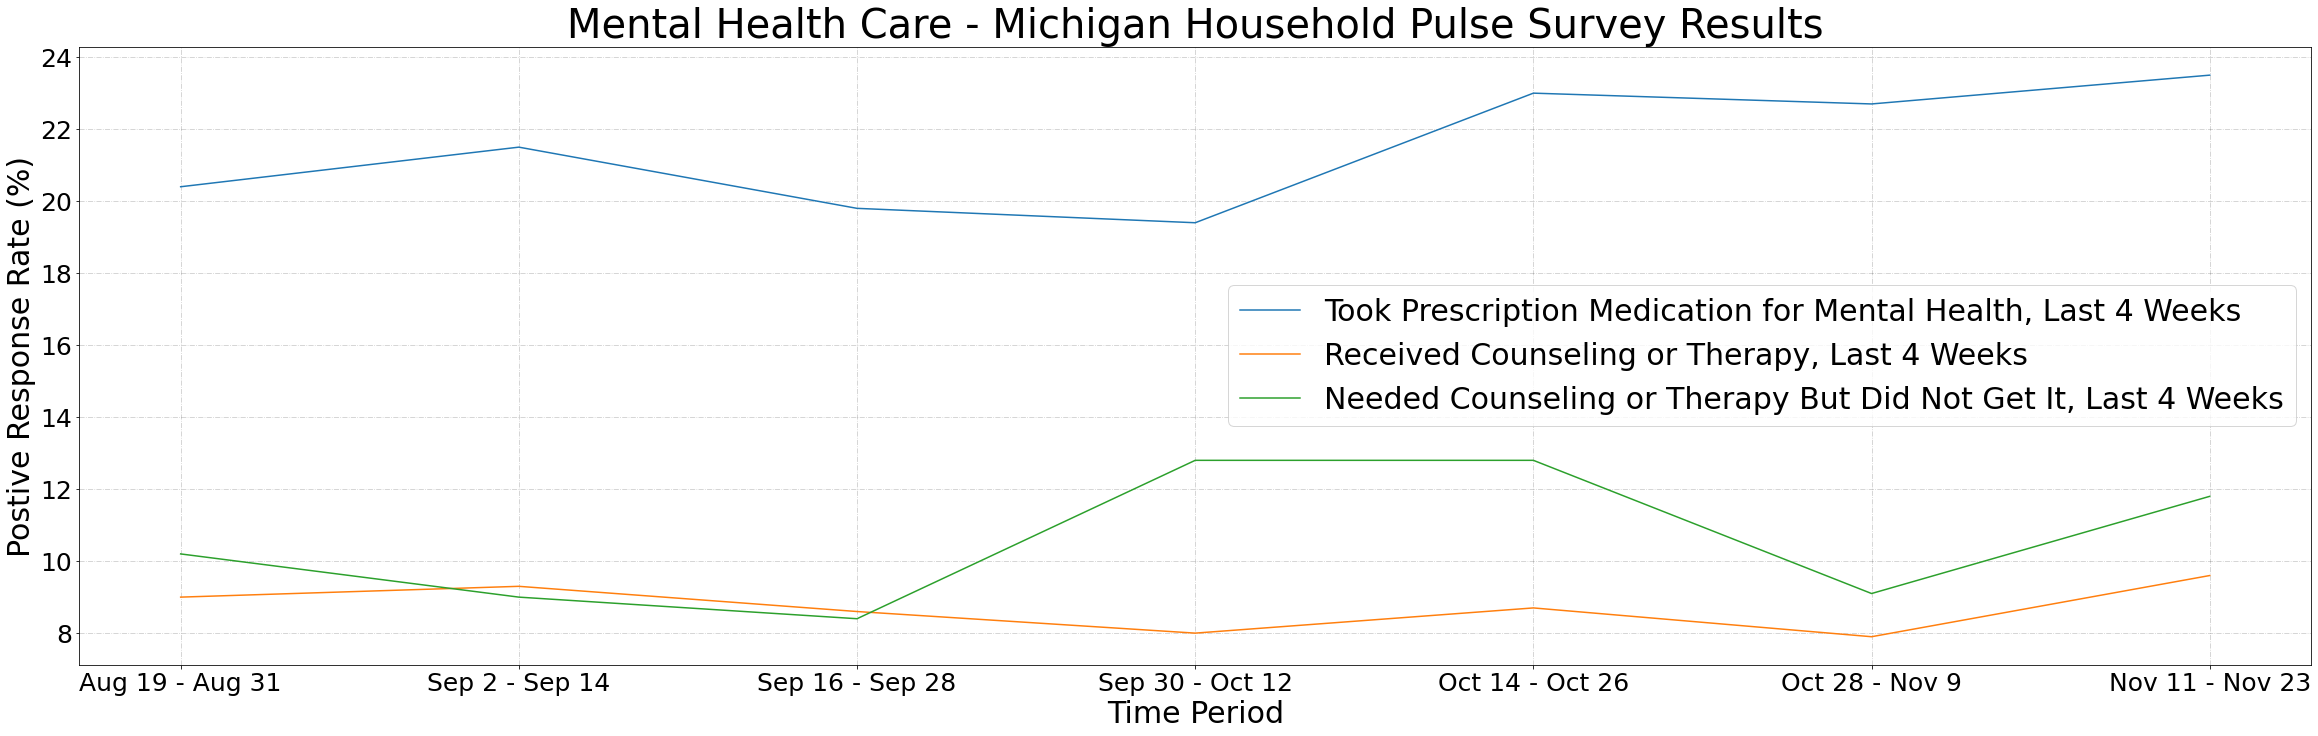

In [ ]:
mental_health_data = pd.read_csv(url_)

mental_health_data.drop(columns = ['Group', 'Subgroup', 'Time Period', 'LowCI', 'HighCI', 'Confidence Interval', 'Quartile Range', 'Suppression Flag', 'Phase'],axis=1 , inplace=True)
mental_health_data = mental_health_data[(mental_health_data.State == "Michigan")]

mental_health_data_presription = mental_health_data[(mental_health_data.Indicator == "Took Prescription Medication for Mental Health, Last 4 Weeks")]
mental_health_data_presription['Rate of Change'] = mental_health_data_presription['Value'].diff()

mental_health_data_counseling_therapy = mental_health_data[(mental_health_data.Indicator == "Received Counseling or Therapy, Last 4 Weeks")]
mental_health_data_counseling_therapy['Rate of Change'] = mental_health_data_counseling_therapy['Value'].diff()

mental_health_data_need = mental_health_data[(mental_health_data.Indicator == "Needed Counseling or Therapy But Did Not Get It, Last 4 Weeks")]
mental_health_data_need['Rate of Change'] = mental_health_data_need['Value'].diff()


fig = plt.figure(figsize = (40, 25)) 
plt.subplot(2, 1, 1)
plt.grid(b = True, color ='black', 
        linestyle ='-.', linewidth = 0.8, 
        alpha = 0.2) 
plt.plot(mental_health_data_presription['Time Period Label'], mental_health_data_presription['Value'], label = "Took Prescription Medication for Mental Health, Last 4 Weeks");
plt.subplot(2, 1, 1)
plt.plot(mental_health_data_counseling_therapy['Time Period Label'], mental_health_data_counseling_therapy['Value'], label = "Received Counseling or Therapy, Last 4 Weeks");
plt.subplot(2, 1, 1)
plt.plot(mental_health_data_need['Time Period Label'], mental_health_data_need['Value'], label = "Needed Counseling or Therapy But Did Not Get It, Last 4 Weeks");
plt.title("Mental Health Care - Michigan Household Pulse Survey Results", fontsize = 40)
plt.ylabel("Postive Response Rate (%)", fontsize = 30)
plt.xlabel("Time Period", fontsize = 30)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.legend(loc="center right", fontsize = 30)


#plt.subplot(2, 1, 2)
##plt.grid(b = True, color ='black', 
 #       linestyle ='-.', linewidth = 0.8, 
 #       alpha = 0.2) 
#plt.plot(mental_health_data_presription['Time Period Label'], mental_health_data_presription['Rate of Change'], label = "Took Prescription Medication for Mental Health, Last 4 Weeks");
#plt.subplot(2, 1, 2);
#plt.plot(mental_health_data_counseling_therapy['Time Period Label'], mental_health_data_counseling_therapy['Rate of Change'], label = "Received Counseling or Therapy, Last 4 Weeks");
#plt.subplot(2, 1, 2);
#plt.plot(mental_health_data_need['Time Period Label'], mental_health_data_need['Rate of Change'], label = "Needed Counseling or Therapy But Did Not Get It, Last 4 Weeks");
#plt.title("Mental Health Care - Michigan Household Pulse Survey Results - Rate of Change", fontsize = 40)
#plt.ylabel("Rate of Change", fontsize = 30)
#plt.xlabel("Time Period", fontsize = 30)
#plt.xticks(fontsize = 25)
#plt.yticks(fontsize = 25)
#plt.legend(loc="upper left", fontsize = 20)





#mental_health_data_presription.head()

Took Prescription Medication for Mental Health, Last 4 Weeks - In August, 20.4% of surveyed adults in MI reported that they took prescription medication for mental health over the last 4 weeks. This number has fluctuated between 19.4% and 23.5%, but is showing a slight positive trend. The latest result collection shows 23.5% positive response rate, the highest rate since the start of the survey.

Received Counseling or Therapy, Last 4 Weeks - In August, 9% of surveyed adults in MI reported that they received counseling or therapy over the last 4 weeks. This number has fluctuated between 7.9% and 9.6%. After reaching a low of 7.9% in the 10/28-11/9 period, the latest results show a survey high of 9.6%. There is no apparent trend in this measure.

Needed Counseling or Therapy But Did Not Get It, Last 4 Weeks - In August, 10.2% of surveyed adults in MI reported that they needed counseling or therapy but did not get it over the last 4 weeks. This number peaked to 12.8% from 9/30 to 10/26, and declined to 11.8% in the latest reportings. There is possibly a slight positive trend in this measure.

**Mental Health Analysis**

To rapidly monitor recent changes in mental health, the National Center for Health Statistics (NCHS) partnered with the Census Bureau on an experimental data system called the Household Pulse Survey. This 20-minute online survey was designed to complement the ability of the federal statistical system to rapidly respond and provide relevant information about the impact of the coronavirus pandemic in the U.S. The data collection period for Phase 1 of the Household Pulse Survey occurred between April 23, 2020 and July 21, 2020. Phase 2 data collection occurred between August 19, 2020 and October 26, 2020.  Phase 3 of the Household Pulse Survey began data collection on October 28, 2020 and will continue through December 21, 2020. 

NCHS included questions to obtain information on the frequency of anxiety and depression symptoms.  The questions are a modified version of the two-item Patient Health Questionnaire (PHQ-2) and the two-item Generalized Anxiety Disorder (GAD-2) scale on the Household Pulse Survey, collecting information on symptoms over the last 7 days. Results show the percentage of adults who report symptoms of anxiety or depression that have been shown to be associated with diagnoses of generalized anxiety disorder or major depressive disorder.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



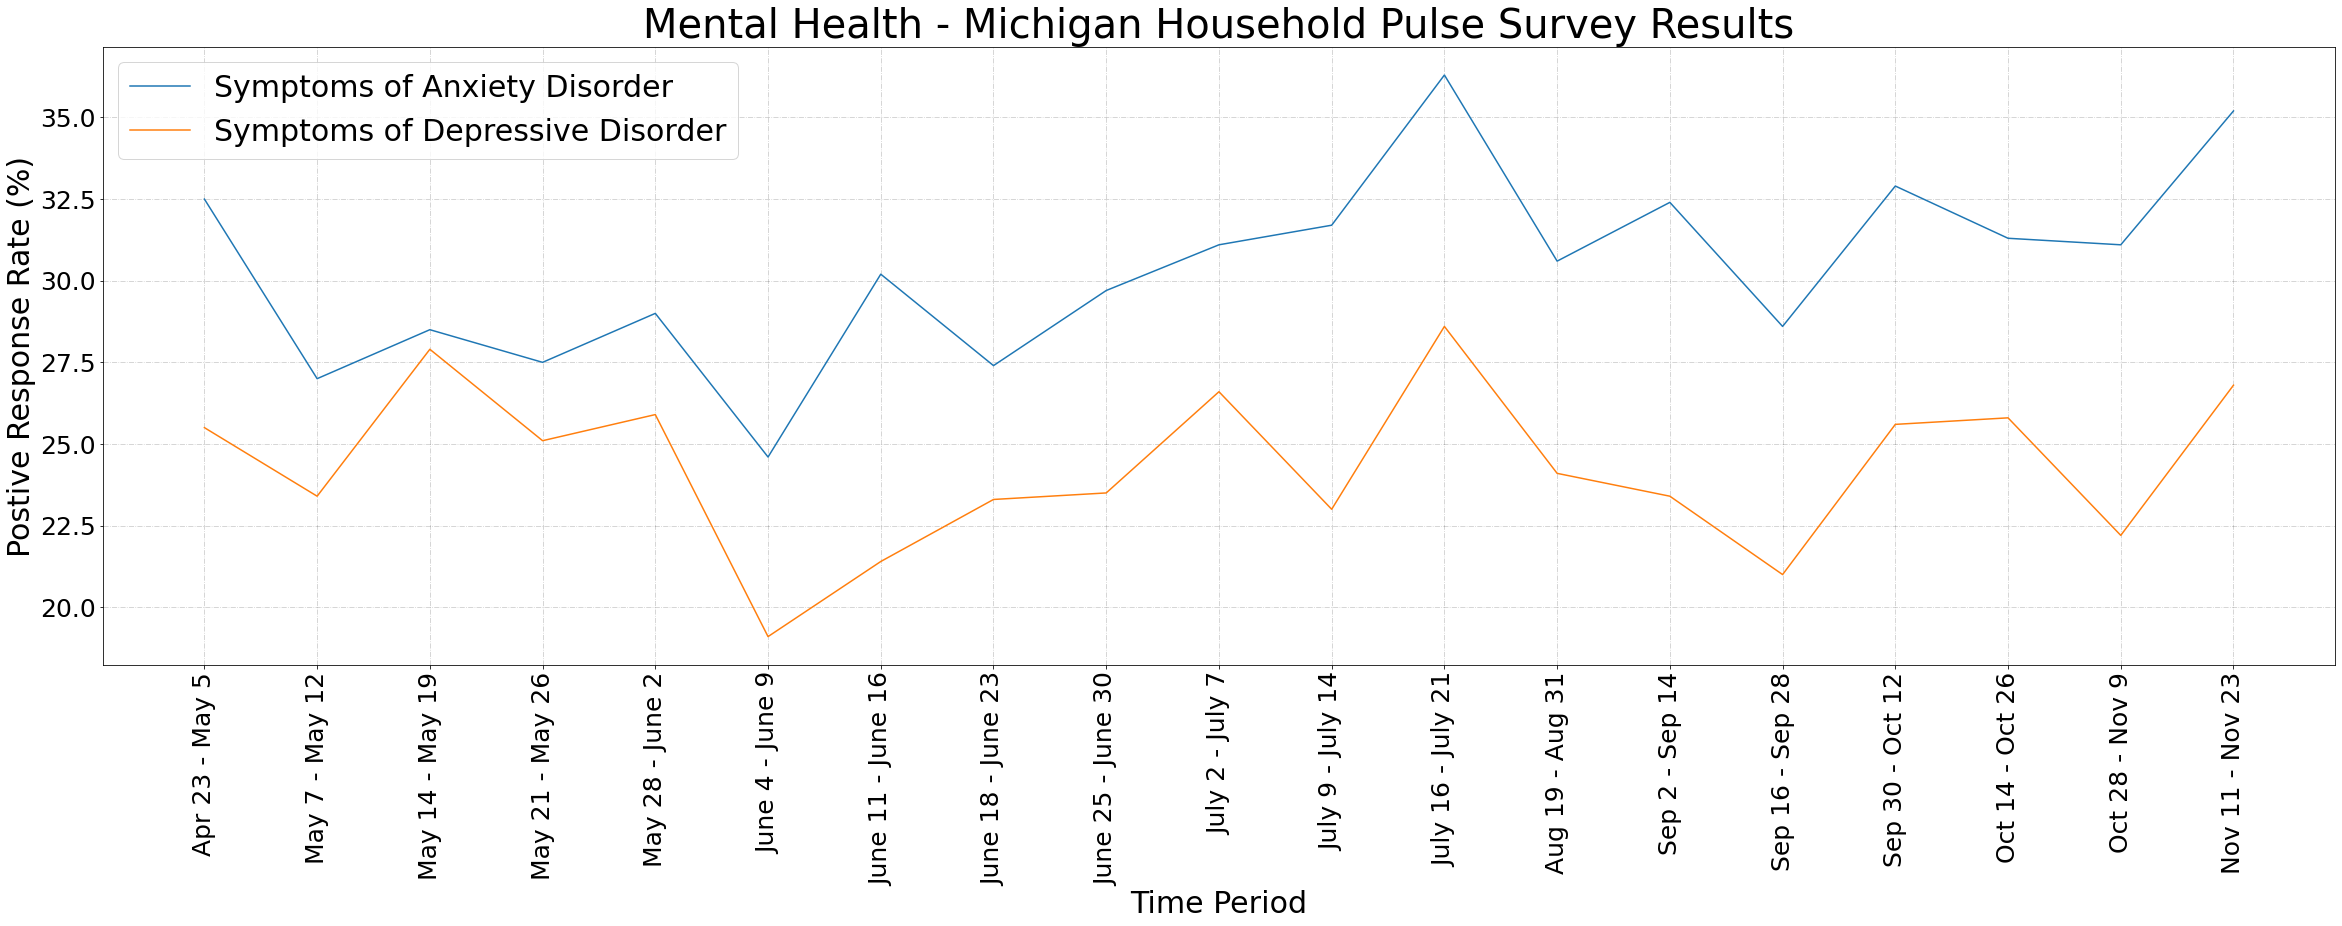

In [ ]:
anxiety_depression_data = pd.read_csv(url_1)

anxiety_depression_data.drop(columns = ['Group', 'Subgroup', 'Time Period', 'Low CI', 'High CI', 'Confidence Interval', 'Quartile range', 'Phase'],axis=1 , inplace=True)
anxiety_depression_data = anxiety_depression_data[(anxiety_depression_data.State == "Michigan")]
anxiety_data = anxiety_depression_data[(anxiety_depression_data.Indicator == "Symptoms of Anxiety Disorder")]
depression_data = anxiety_depression_data[(anxiety_depression_data.Indicator == "Symptoms of Depressive Disorder")]

fig = plt.figure(figsize = (40, 25)) 
plt.subplot(2, 1, 1)
plt.grid(b = True, color ='black', 
        linestyle ='-.', linewidth = 0.8, 
        alpha = 0.2) 
plt.plot(anxiety_data['Time Period Label'], anxiety_data['Value'], label = "Symptoms of Anxiety Disorder")
plt.subplot(2, 1, 1)
plt.plot(depression_data['Time Period Label'], depression_data['Value'], label = "Symptoms of Depressive Disorder")

plt.title("Mental Health - Michigan Household Pulse Survey Results", fontsize = 40)
plt.ylabel("Postive Response Rate (%)", fontsize = 30)
plt.xlabel("Time Period", fontsize = 30)
plt.xticks(rotation = 'vertical', fontsize = 25)
plt.yticks(fontsize = 25)


plt.legend(loc="upper left", fontsize = 30)


Symptoms of Anxiety Disorder - In April, 32.5% of surveyed adults in MI reported that they experienced symptoms of anxiety disorder over the past week. This number has fluctuated between 25% and 36.3%, but is showing a slight positive trend. The peak response rate was during 7/16 - 7/21, while the minimum response rate was during 6/4 - 6/9. Interestingly, the minimum response rate came days after the executive stay at home order was lifted. The latest results show anxiety symptoms increasing to 35.2%, the second highest rate thus far.

Symptoms of Depressive Disorder - In April, 25.5% of surveyed adults in MI reported that they experienced symptoms of depressive disorder over the past week. This number has fluctuated between 19.1% and 28.6%, with no apparent trend. The peak response rate was during 7/16 - 7/21, while the minimum response rate was during 6/4 - 6/9. Interestingly, the minimum response rate came days after the executive stay at home order was lifted. The latest results show depressive symptoms increasing to 26.8%, the third highest rate thus far.

#**Query Items**
3 Needed

In [ ]:
#County Data Means by MERC_Regions
MergeData2.groupby(['MERC_Regions']).mean()


pop2020  ...  Case_Death_Rate
MERC_Regions                         ...                 
Detroit Region        585317.111111  ...         0.022903
Grand Rapids Region   119141.153846  ...         0.014541
Jackson Region        100828.000000  ...         0.017083
Kalamazoo Region      107955.111111  ...         0.013893
Lansing Region        118481.200000  ...         0.014568
Saginaw Region         50355.250000  ...         0.022457
Traverse City Region   26371.294118  ...         0.018162
Upper Peninsula        19940.066667  ...         0.019857

[8 rows x 12 columns]

In [ ]:
# average confirmed cases and deaths by region
pd.pivot_table(MergeData3, values = ['Confirmed_Cases' , 'Confirmed_Deaths'] , index = 'MERC_Regions' , aggfunc = np.mean)

Confirmed_Cases  Confirmed_Deaths
MERC_Regions                                           
Detroit Region           16900.333333        527.333333
Grand Rapids Region       4856.538462         60.615385
Jackson Region            3051.666667         53.000000
Kalamazoo Region          3781.444444         61.555556
Lansing Region            3477.600000         47.200000
Saginaw Region            1679.333333         40.000000
Traverse City Region       509.411765         10.058824
Upper Peninsula            782.400000         14.800000

In [ ]:
# sum of confirmed cases by region and county
pd.pivot_table(MergeData3, values = ['Case_Death_Rate' , 'Confirmed_Deaths'] , 
               index = ['MERC_Regions' , 'COUNTY']  , aggfunc = np.sum)

Case_Death_Rate  Confirmed_Deaths
MERC_Regions    COUNTY                                        
Detroit Region  Genesee             0.028558               392
                Lapeer              0.021580                52
                Livingston          0.008522                46
                Macomb              0.034636              1211
                Monroe              0.014604                75
...                                      ...               ...
Upper Peninsula Mackinac            0.000000                 0
                Marquette           0.010912                30
                Menominee           0.013097                17
                Ontonagon           0.050909                13
                Schoolcraft         0.011561                 1

[83 rows x 2 columns]

In [ ]:
#County Data Means by Population Density Bins
MergeData2.groupby(['Population_Density_Bins']).mean()

pop2020  ...  Case_Death_Rate
Population_Density_Bins                 ...                 
(0, 100]                  25357.058824  ...         0.019478
(100, 500]               139951.851852  ...         0.014352
(500, 10000]             992588.200000  ...         0.027897

[3 rows x 12 columns]

To run Spark SQL, the first thing we need to do is import the neccessary Spark libraries:

In [ ]:
%%bash
apt-get install openjdk-8-jdk-headless -qq > /dev/null
[ ! -e "$(basename spark-3.0.1-bin-hadoop2.7.tgz)" ] && wget  http://apache.osuosl.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz  
tar xf spark-3.0.1-bin-hadoop2.7.tgz
pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"

In [ ]:
import findspark
findspark.init()
findspark.find()
import pyspark
from pyspark import SparkContext,SparkConf
from pyspark.sql import SparkSession

In [ ]:
spark = SparkSession.builder.master("local[*]").getOrCreate()

Converting data type for Population Bins variable to a string; PySpark does not recognize the "character" data type

In [ ]:
MergeData3['Population_Density_Bins'] = MergeData3['Population_Density_Bins'].astype(str)


In [ ]:
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled" , "true")
sparkpdf = spark.createDataFrame(MergeData3)
# spark will automatically infer the schema 

sparkpdf.show()

/content/spark-3.0.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:289: UserWarning:

createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 0.15.1 must be installed; however, your version was 0.14.1.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.



+----------+-------+----------------+--------------+-----------+---------------+----------------+--------------+---------------+-------------------+------------------+-----------------------+------------------+-------------------+--------------------+----------+-----------+-----+
|    COUNTY|pop2020|Count_Diagnostic|Count_Serology|Count_Total|Confirmed_Cases|Confirmed_Deaths|Probable_Cases|Probable_Deaths|       MERC_Regions|Population_Density|Population_Density_Bins|         Test_Rate|Confirmed_Case_Rate|     Case_Death_Rate|State_Code|County_Code| FIPS|
+----------+-------+----------------+--------------+-----------+---------------+----------------+--------------+---------------+-------------------+------------------+-----------------------+------------------+-------------------+--------------------+----------+-----------+-----+
|     Wayne|1749150|          735038|         51356|     786394|          39152|            1457|          2910|             58|     Detroit Region|         

Now that the Pandas dataframe has been successfully converted to Pyspark, we can run SQL queries. Here is confirmation that the data types were successfully transferred from Pandas. This will be important for us when we run SQL codes.

In [ ]:
sparkpdf.dtypes

[('COUNTY', 'string'),
 ('pop2020', 'bigint'),
 ('Count_Diagnostic', 'bigint'),
 ('Count_Serology', 'bigint'),
 ('Count_Total', 'bigint'),
 ('Confirmed_Cases', 'bigint'),
 ('Confirmed_Deaths', 'bigint'),
 ('Probable_Cases', 'bigint'),
 ('Probable_Deaths', 'bigint'),
 ('MERC_Regions', 'string'),
 ('Population_Density', 'double'),
 ('Population_Density_Bins', 'string'),
 ('Test_Rate', 'double'),
 ('Confirmed_Case_Rate', 'double'),
 ('Case_Death_Rate', 'double'),
 ('State_Code', 'bigint'),
 ('County_Code', 'string'),
 ('FIPS', 'string')]

In [ ]:
sparkpdf.registerTempTable('mytable') 
RegionLookUp = spark.sql(""" 
    SELECT County, pop2020, MERC_Regions, Confirmed_Deaths 
    FROM mytable 
    WHERE MERC_Regions = 'Detroit Region' AND Confirmed_Deaths > 500
    ORDER BY Confirmed_Deaths DESC
    """)
RegionLookUp.show(RegionLookUp.count())
RegionLookUp.count()

+-------+-------+--------------+----------------+
| County|pop2020|  MERC_Regions|Confirmed_Deaths|
+-------+-------+--------------+----------------+
|  Wayne|1749150|Detroit Region|            1457|
|Oakland|1265240|Detroit Region|            1299|
| Macomb| 880325|Detroit Region|            1211|
+-------+-------+--------------+----------------+



3

Displaying the top 20 Michigan counties in terms of number of confirmed cases along with their MERC_Regions.

In [ ]:
sparkpdf.registerTempTable('mytable') 
RegionLookUp = spark.sql(""" 
    SELECT County, MERC_Regions, Confirmed_Cases
    FROM mytable
    ORDER BY Confirmed_Cases DESC
    LIMIT 10
    """)
RegionLookUp.show(RegionLookUp.count())
RegionLookUp.count()

+---------+-------------------+---------------+
|   County|       MERC_Regions|Confirmed_Cases|
+---------+-------------------+---------------+
|  Oakland|     Detroit Region|          40160|
|    Wayne|     Detroit Region|          39152|
|   Macomb|     Detroit Region|          34994|
|     Kent|Grand Rapids Region|          31021|
|   Ottawa|Grand Rapids Region|          12954|
|  Genesee|     Detroit Region|          12935|
|Washtenaw|     Detroit Region|           9006|
|   Ingham|     Lansing Region|           8675|
|Kalamazoo|   Kalamazoo Region|           8026|
|  Saginaw|     Saginaw Region|           7979|
+---------+-------------------+---------------+



10

Displaying counties with a population of 250k or higher but with a less than 25k confirmed cases.


In [ ]:
sparkpdf.registerTempTable('mytable') 
RegionLookUp = spark.sql(""" 
    SELECT County, pop2020, MERC_Regions, Confirmed_Cases 
    FROM mytable 
    WHERE pop2020 > 250000 AND Confirmed_Cases < 25000
    ORDER BY Confirmed_Cases DESC
    """)
RegionLookUp.show(RegionLookUp.count())
RegionLookUp.count()

+---------+-------+-------------------+---------------+
|   County|pop2020|       MERC_Regions|Confirmed_Cases|
+---------+-------+-------------------+---------------+
|   Ottawa| 297638|Grand Rapids Region|          12954|
|  Genesee| 405330|     Detroit Region|          12935|
|Washtenaw| 374473|     Detroit Region|           9006|
|   Ingham| 293551|     Lansing Region|           8675|
|Kalamazoo| 268608|   Kalamazoo Region|           8026|
+---------+-------+-------------------+---------------+



5

On the other hand, displaying counties with a population less than 250k but more than 10k confirmed cases.

In [ ]:
sparkpdf.registerTempTable('mytable') 
RegionLookUp = spark.sql(""" 
    SELECT County, pop2020, MERC_Regions, Confirmed_Cases 
    FROM mytable 
    WHERE pop2020 < 250000 AND Confirmed_Cases > 10000
    ORDER BY Confirmed_Cases DESC
    """)
RegionLookUp.show(RegionLookUp.count())
RegionLookUp.count()

+------+-------+------------+---------------+
|County|pop2020|MERC_Regions|Confirmed_Cases|
+------+-------+------------+---------------+
+------+-------+------------+---------------+



0

#**In Conclusion**



*   The Detroit Region (which consists of Wayne, Oakland, Macomb, Genessee, Lapeer, and Livingston counties) has 53% of the state's population, yet has 64% of confirmed deaths as of November 30, 2020

*   The counties with the most COVID-19 cases are: 1. Wayne, 2. Oakland, 3. Macomb, 4. Kent, and 5. Genessee

*   The counties with the most COVID-19 deaths are: 1. Wayne, 2. Oakland, 3. Macomb, 4. Genessee, and 5. Kent

*   The largest rate of change of COVID-19 cases started in November and is continuing through present day

*   The rate of change of COVID-19 deaths was greatest from April to June and from November through present day

*   Unemployment rates in MI rose to 24% and to 14.7% nationwide in April 2020 after holding consistently under 5% since January 2018 

*   There was not a significant rise in mental health care needs and mental health disorder symptoms from the start of the NCHS COVID-19 mental health studies to present day, despite stay at home orders, rising unempoyment, and rising cases and deaths

*   Correlation matrices show that there is strong positive correlation between population size and confirmed cases, confirmed deaths, and total testing. This is to be expected as these tend to scale with population

*   Correlation matrices also show very high correlation between total testing and confirmed cases/confirmed deaths. This is to be expected since one would logically assume that with more testing comes more poitive test results

*    Some MERC regions appear to have positive correlation between population density and death rate while others have a negative correlation. The reason there are some counties that have negative correltaion is due to there being large variations in death rates in the more rural counties than in the more populated counties

*    With increasing population density there is less variation in Case Rate and Death Rate

